# pca

In [54]:
# ================================
# PCA (Excel, Jupyter) — EN labels, stable plots, KMO-selection, pretty outputs
# + Tables: component matrix, assigned variables (threshold), communalities
# ================================

## -----------------------------------------------------------
## >>> EDIT HERE: PATHS, VARIABLES, THRESHOLDS (single place)
## -----------------------------------------------------------
base_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"   # <<< change if needed
excel_file <- file.path(base_dir, "Sophia_Data.xls")                      # <<< exact Excel filename
sheet_name <- NULL                                                        # <<< e.g. "Sheet1"; NULL = first
out_dir    <- file.path(base_dir, "PCA_ohneKohlenstoff_mitwassertemp")                         # <<< output folder

# PCA_alles_ohnewassertemp
# PCA_alles_wassertemp
# PCA_ohneCO2_ohnewassertemp
# PCA_ohneCO2_mitwassertemp
# PCA_ohneKohlenstoff_ohnewassertemp
# PCA_ohneKohlenstoff_mitwassertemp


VARS <- c(  # <<< variables to consider
 # "average_DOC_sample","BDOC_pct",
 # "CO2_Flux",
  "Chlorophyll_ugperL",
  "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
  "Temp_C",
  "pctComp.1","pctComp.2","pctComp.3","pctComp.4","pctComp.5","Air_temp"
)

# "average_DOC_sample","BDOC_pct","CO2_Flux",

KMO_TARGET  <- 0.70   # <<< set your KMO target here (e.g., 0.50, 0.60, 0.70 …)
LOAD_THRESH <- 0.50   # <<< absolute loading cutoff for "assigned variables" tables

## -----------------------------------------------------------
## Packages
## -----------------------------------------------------------
req <- c("readxl","psych","dplyr","ggplot2","corrplot","tibble",
         "knitr","GPArotation","ggrepel","Matrix","factoextra","grid")
to_install <- req[!req %in% rownames(installed.packages())]
if(length(to_install) > 0) install.packages(to_install, quiet = TRUE)
invisible(lapply(req, library, character.only = TRUE))

## -----------------------------------------------------------
## Helpers (no HTML)
## -----------------------------------------------------------
if(!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)
graphics.off()
show_h1 <- function(txt){ cat("\n\n==== ", txt, " ====\n", sep="") }
note    <- function(txt){  cat("Note: ", txt, "\n", sep = "") }
warnln  <- function(txt){  cat("⚠️  ", txt, "\n", sep = "") }
okln    <- function(txt){  cat("✅ ", txt, "\n", sep = "") }
show_tbl<- function(df, caption=NULL){ print(knitr::kable(df, format="simple", caption=caption, align="l")) }

to_numeric_df <- function(df){
  out <- df
  out[] <- lapply(out, function(x){
    if(is.character(x) || is.factor(x)){ x <- gsub(",", ".", as.character(x)); suppressWarnings(as.numeric(x)) }
    else { suppressWarnings(as.numeric(x)) }
  })
  out
}

# stable plotting: show first, then save
plot_save_show_gg <- function(p, file, width_cm=18, height_cm=12, dpi=300){
  print(p)  # show in notebook
  ggplot2::ggsave(filename = file, plot = p, width = width_cm, height = height_cm, units = "cm", dpi = dpi)
}
plot_save_show_base <- function(plot_expr, file, width_px=1800, height_px=1400, res=180){
  graphics.off(); par(mfrow=c(1,1))
  eval.parent(substitute(plot_expr))                 # show
  png(filename = file, width = width_px, height = height_px, res = res)
  par(mfrow=c(1,1))
  eval.parent(substitute(plot_expr))                 # save
  dev.off()
  invisible(NULL)
}

## -----------------------------------------------------------
## Load data
## -----------------------------------------------------------
stopifnot("Excel file not found." = file.exists(excel_file))
sheets <- readxl::excel_sheets(excel_file); if(is.null(sheet_name)) sheet_name <- sheets[1]
raw <- read_excel(excel_file, sheet = sheet_name)

if(!all(VARS %in% names(raw))){
  miss <- setdiff(VARS, names(raw))
  stop(paste0("Missing variables in '", sheet_name, "': ", paste(miss, collapse=", ")))
}

dat <- raw[, VARS, drop = FALSE]
dat_num <- to_numeric_df(dat)

n0 <- nrow(dat_num)
dat_cc <- na.omit(dat_num)
n_used <- nrow(dat_cc); n_removed <- n0 - n_used

show_h1("Data overview")
show_tbl(data.frame(Total_rows=n0, Complete_rows=n_used, Removed_due_to_NA=n_removed),
         "Row counts")

## -----------------------------------------------------------
## KMO-driven variable selection (stabilises PCA)
## -----------------------------------------------------------
kmo_for <- function(df, cols){
  X <- df[, cols, drop=FALSE]; X <- X[complete.cases(X), , drop=FALSE]
  if(nrow(X) < 10 || ncol(X) < 3) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=NULL))
  sds <- sapply(X, sd, na.rm=TRUE); if(any(sds<=0 | !is.finite(sds))) X <- X[, sds>0 & is.finite(sds), drop=FALSE]
  if(ncol(X) < 3) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=NULL))
  R <- suppressWarnings(cor(X, use="complete.obs"))
  ev <- eigen((R+t(R))/2, symmetric=TRUE, only.values=TRUE)$values
  if(min(ev) <= 1e-8) R <- as.matrix(Matrix::nearPD(R, corr=TRUE)$mat)
  km <- tryCatch(psych::KMO(R), error=function(e) NULL)
  if(is.null(km)) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=R))
  list(ok=TRUE, KMO=as.numeric(km$MSA), MSAi=km$MSAi, R=R)
}
round_ok <- function(x) !is.na(x) && (round(x,2) >= KMO_TARGET)

vars_all <- intersect(VARS, colnames(dat_cc))
comp_in  <- intersect(grep("^pctComp\\.", vars_all, value=TRUE), vars_all)
cur <- vars_all
history <- tibble::tibble(Step=0L, p=length(cur), Removed="–", Set="start", KMO=NA_real_)
res <- kmo_for(dat_cc, cur); history$KMO[1] <- res$KMO

best_set <- cur; best_res <- res
if(length(comp_in) > 0){
  for(k in 1:length(comp_in)){
    cmb <- combn(comp_in, k, simplify=FALSE)
    evals <- lapply(cmb, function(rem){
      cols <- setdiff(vars_all, rem)
      list(rem=rem, out=kmo_for(dat_cc, cols), cols=cols)
    })
    ok <- Filter(function(z) isTRUE(z$out$ok), evals)
    if(length(ok)){
      ks <- sapply(ok, function(z) z$out$KMO); imax <- which.max(ks); cand <- ok[[imax]]
      history <- dplyr::add_row(history, Step=nrow(history), p=length(cand$cols),
                                Removed=paste(cand$rem, collapse=", "), Set="only_pctComp", KMO=cand$out$KMO)
      if(round_ok(cand$out$KMO)){ best_set <- cand$cols; best_res <- cand$out; break }
      if(is.na(best_res$KMO) || cand$out$KMO > best_res$KMO){ best_set <- cand$cols; best_res <- cand$out }
    }
  }
  cur <- best_set; res <- best_res
}
if(!round_ok(res$KMO)){
  improved <- TRUE
  while(!round_ok(res$KMO) && improved && length(cur) > 3){
    improved <- FALSE
    trials <- lapply(seq_along(cur), function(i){
      cand <- cur[-i]; out <- kmo_for(dat_cc, cand)
      list(var=cur[i], KMO=out$KMO, ok=out$ok, cols=cand, out=out)
    })
    trials <- Filter(function(z) isTRUE(z$ok), trials); if(length(trials)==0) break
    imax <- which.max(sapply(trials, `[[`, "KMO")); pick <- trials[[imax]]
    if(is.na(res$KMO) || (pick$KMO > res$KMO + 1e-4)){
      history <- dplyr::add_row(history, Step=nrow(history), p=length(pick$cols),
                                Removed=pick$var, Set="greedy_rest", KMO=pick$KMO)
      cur <- pick$cols; res <- pick$out; improved <- TRUE
    } else break
  }
}
SEL_VARS <- cur
show_h1("KMO-driven selection")
show_tbl(history, "KMO path (steps)")
write.csv(history, file.path(out_dir, "KMO_path_selection.csv"), row.names=FALSE)
kmo_df <- data.frame(Variable=names(res$MSAi), MSA=round(as.numeric(res$MSAi),3)) %>% dplyr::arrange(MSA)
show_tbl(kmo_df, "MSA per variable (ascending)")
write.csv(kmo_df, file.path(out_dir, "KMO_MSA_final.csv"), row.names=FALSE)

## -----------------------------------------------------------
## Correlation & eigenvalues (selected vars) + correlation triangle
## -----------------------------------------------------------
dat_cc_sel <- dat_cc[, SEL_VARS, drop=FALSE]
R    <- cor(dat_cc_sel, use = "pairwise.complete.obs")
ev_R <- eigen(R, symmetric=TRUE, only.values=TRUE)$values
write.csv(round(R,3),    file.path(out_dir,"01_Correlation_matrix.csv"))
write.csv(round(ev_R,6), file.path(out_dir,"02_Eigenvalues_of_R.csv"), row.names=FALSE)

show_h1("Correlation matrix & eigenvalues")
show_tbl(round(R,3), "Correlation matrix (Pearson)")
ev_tbl <- data.frame(Component=paste0("EV", seq_along(ev_R)), Eigenvalue=round(ev_R,4))
show_tbl(ev_tbl, "Eigenvalues of correlation matrix")

# Pretty block: Matrix definiteness (display + save)
classify_definiteness <- function(ev, abs_tol = 1e-8, rel_tol = 1e-6){
  thr <- max(abs_tol, rel_tol * max(abs(ev), na.rm = TRUE))
  pd  <- all(ev >  thr, na.rm = TRUE)
  psd <- all(ev >= -thr, na.rm = TRUE)
  sing <- psd && any(ev <  thr, na.rm = TRUE)
  status <- if(pd) "positive definite" else if(sing) "positive semidefinite (singular)" else if(psd) "positive semidefinite" else "NOT positive semidefinite"
  list(status=status, thr=thr, pd=pd, psd=psd, singular=sing)
}
pretty_definiteness <- function(R, ev, out_dir){
  det_R <- det(R)
  kap   <- tryCatch(kappa(R), error=function(e) NA_real_)
  rcond <- if(is.finite(kap)) 1/kap else NA_real_
  dres  <- classify_definiteness(ev)
  show_h1("Definiteness of correlation matrix (pretty)")
  cat("Min EV: ", signif(min(ev),6), " | Max EV: ", signif(max(ev),6),
      " | threshold thr: ", signif(dres$thr,3), "\n", sep="")
  cat("det(R): ", signif(det_R,6),
      " | kappa: ", if(is.finite(kap)) signif(kap,6) else "NA",
      " | 1/kappa: ", if(is.finite(rcond)) signif(rcond,6) else "NA", "\n", sep="")
  cat("Classification: ", dres$status, "\n", sep="")
  if(dres$status == "positive definite"){
    okln("Matrix is positive definite → PCA is numerically stable.")
  } else if(dres$status == "positive semidefinite (singular)"){
    warnln("Matrix is only positive semidefinite (singular) → near-linear dependencies.")
  } else if(dres$status == "positive semidefinite"){
    warnln("Matrix is positive semidefinite (not strictly PD) → caution with inversions.")
  } else {
    warnln("Matrix is NOT positive semidefinite → negative eigenvalues present.")
  }
  con <- file.path(out_dir, "01c_Definiteness_pretty.txt")
  sink(con)
  cat("==== Correlation Matrix Definiteness ====\n")
  cat("Min EV: ", signif(min(ev),6), " | Max EV: ", signif(max(ev),6),
      " | threshold thr: ", signif(dres$thr,3), "\n", sep="")
  cat("det(R): ", signif(det_R,6),
      " | kappa: ", if(is.finite(kap)) signif(kap,6) else "NA",
      " | 1/kappa: ", if(is.finite(rcond)) signif(rcond,6) else "NA", "\n", sep="")
  cat("Classification: ", dres$status, "\n", sep="")
  sink()
  invisible(dres)
}
dres <- pretty_definiteness(R, ev_R, out_dir)

# Correlation triangle — show & save
show_h1("Correlation triangle (upper)")
plot_save_show_base(
  corrplot::corrplot(R, type="upper", order="hclust", tl.col="black",
                     addCoef.col="black", number.cex=0.6),
  file = file.path(out_dir,"01b_CorrTriangle.png"),
  width_px = 1800, height_px = 1600, res = 200
)

## -----------------------------------------------------------
## Component selection criteria (PCA only)
## -----------------------------------------------------------
# 1) Kaiser (EV > 1)
n_kaiser <- sum(ev_R > 1)
kaiser_tbl <- data.frame(
  Component = seq_along(ev_R),
  Eigenvalue = round(ev_R,4),
  Kaiser_gt1 = ev_R > 1
)
show_h1("Criterion 1 — Kaiser (eigenvalue > 1)")
show_tbl(kaiser_tbl, "Kaiser rule table")
write.csv(kaiser_tbl, file.path(out_dir, "20_Components_Kaiser.csv"), row.names=FALSE)

# 2) Scree plot
show_h1("Criterion 2 — Scree plot")
scree_df <- data.frame(Component=seq_along(ev_R), Eigenvalue=ev_R)
p_scree <- ggplot(scree_df, aes(Component, Eigenvalue))+
  geom_point(size=2)+geom_line()+
  geom_hline(yintercept=1, linetype="dashed")+
  labs(title="Scree plot (eigenvalues of correlation matrix)", x="Component", y="Eigenvalue")+
  theme_minimal(base_size = 12)
plot_save_show_gg(p_scree, file.path(out_dir,"21_Screeplot.png"))

# 3) Parallel analysis (PCA)
#show_h1("Criterion 3 — Parallel analysis (PCA)")
#graphics.off(); par(mfrow=c(1,1))
#fa.parallel(dat_cc_sel, fm="pc", fa="pc", main="Parallel analysis (PCA)")
#png(file.path(out_dir,"22_Parallel_Analysis.png"), width=1800, height=1200, res=180)
#par(mfrow=c(1,1))
#fa.parallel(dat_cc_sel, fm="pc", fa="pc", main="Parallel analysis (PCA)")
#dev.off()
#pa_res <- fa.parallel(dat_cc_sel, fm="pc", fa="pc", plot=FALSE)
#n_pa <- sum(pa_res$pc.values > pa_res$pc.sim)
#cat("Results → PA: ", n_pa, " components | Kaiser: ", n_kaiser, " components.\n", sep="")

# --------- Criterion 3 — Parallel analysis (PCA) ---------
show_h1("Criterion 3 — Parallel analysis (PCA)")
graphics.off(); par(mfrow=c(1,1))

# Nur PCA: KEIN fm=..., einfach fa="pc"
##psych::fa.parallel(dat_cc_sel, fa="pc", main="Parallel analysis (PCA)")
psych::fa.parallel(dat_cc_sel, fa="pc", plot=FALSE)

png(file.path(out_dir,"22_Parallel_Analysis.png"), width=1800, height=1200, res=180)
par(mfrow=c(1,1))
##psych::fa.parallel(dat_cc_sel, fa="pc", main="Parallel analysis (PCA)")
psych::fa.parallel(dat_cc_sel, fa="pc", plot=FALSE)

dev.off()

##pa_res <- psych::fa.parallel(dat_cc_sel, fa="pc", plot=FALSE)
psych::fa.parallel(dat_cc_sel, fa="pc", plot=FALSE)

n_pa   <- sum(pa_res$pc.values > pa_res$pc.sim)
cat("Results → PA: ", n_pa, " components | (PCA mode)\n", sep="")


      
# Final choice: Kaiser
ncomp <- max(1, n_kaiser)
show_h1("Final number of components (chosen: Kaiser)")
cat("ncomp = ", ncomp, " (eigenvalue > 1)\n", sep="")

## -----------------------------------------------------------
## PCA (unrotated & varimax) + tables & biplots
## -----------------------------------------------------------
pca_unrot <- psych::principal(dat_cc_sel, nfactors=ncomp, rotate="none",   scores=TRUE, covar=FALSE)
pca_rot   <- psych::principal(dat_cc_sel, nfactors=ncomp, rotate="varimax", scores=TRUE, covar=FALSE)

# Variance tables
var_unrot <- data.frame(
  Component = paste0("PC",seq_len(ncomp)),
  Eigenvalue = round(pca_unrot$values[seq_len(ncomp)],4),
  Proportion = round(pca_unrot$Vaccounted["Proportion Var",seq_len(ncomp)],4),
  Cumulative = round(pca_unrot$Vaccounted["Cumulative Var",seq_len(ncomp)],4)
)
show_h1("Variance explained — unrotated"); show_tbl(var_unrot)
write.csv(var_unrot, file.path(out_dir,"06_Variance_unrotated.csv"), row.names=FALSE)

var_rot <- data.frame(
  Component = paste0("PC",seq_len(ncomp)),
  Eigenvalue_rot   = round(pca_rot$values[seq_len(ncomp)],4),
  Proportion_rot   = round(pca_rot$Vaccounted["Proportion Var",seq_len(ncomp)],4),
  Cumulative_rot   = round(pca_rot$Vaccounted["Cumulative Var",seq_len(ncomp)],4)
)
show_h1("Variance explained — varimax"); show_tbl(var_rot)
write.csv(var_rot, file.path(out_dir,"09_Variance_varimax.csv"), row.names=FALSE)

# Loadings & Communalities (unrotated)
load_unrot <- as.data.frame(unclass(pca_unrot$loadings))
commu_unrot<- data.frame(Variable=rownames(load_unrot),
                         Communality=round(rowSums(load_unrot^2),6))
write.csv(round(load_unrot,6), file.path(out_dir,"07_Loadings_unrotated.csv"))
write.csv(commu_unrot,       file.path(out_dir,"08_Communalities_unrotated.csv"), row.names=FALSE)

# Loadings (varimax) & Communalities
load_rot <- as.data.frame(unclass(pca_rot$loadings))
commu_rot<- data.frame(Variable=rownames(load_rot),
                       Communality_rot=round(rowSums(load_rot^2),6))
write.csv(round(load_rot,6), file.path(out_dir,"10_Loadings_varimax.csv"))
write.csv(commu_rot,       file.path(out_dir,"11_Communalities_varimax.csv"), row.names=FALSE)

## --------------------------
## TABLE 1: Component matrix (unrotated) — show & save
## --------------------------
show_h1(sprintf("Component matrix (unrotated) — %d components", ncomp))
comp_mat_unrot <- round(load_unrot[, seq_len(ncomp), drop=FALSE], 3)
colnames(comp_mat_unrot) <- paste0("Component ", seq_len(ncomp))
comp_mat_unrot <- cbind(Variable = rownames(comp_mat_unrot), comp_mat_unrot, row.names = NULL)
show_tbl(comp_mat_unrot, "Correlation coefficients (loadings) per component")
write.csv(comp_mat_unrot, file.path(out_dir,"30_ComponentMatrix_unrotated.csv"), row.names=FALSE)

## --------------------------
## TABLE 2: Assigned variables (unrotated, threshold)
## keep only the component with max |loading| per variable if >= LOAD_THRESH
## --------------------------
assign_by_threshold <- function(L, thr=0.5){
  A <- as.matrix(L[, seq_len(ncol(L)), drop=FALSE])
  rn <- rownames(A); cn <- colnames(A)
  sel <- apply(abs(A), 1, function(v){
    if(all(is.na(v))) return(rep(NA_real_, length(v)))
    j <- which.max(abs(v)); out <- rep(NA_real_, length(v))
    if(is.finite(v[j]) && abs(v[j]) >= thr) out[j] <- ifelse(is.na(v[j]), NA, v[j])
    out
  })
  B <- t(sel); colnames(B) <- cn; rownames(B) <- rn
  as.data.frame(B)
}
show_h1(sprintf("Assigned variables (unrotated) — |loading| ≥ %.2f", LOAD_THRESH))
ass_unrot <- assign_by_threshold(load_unrot[, seq_len(ncomp), drop=FALSE], thr=LOAD_THRESH)
colnames(ass_unrot) <- paste0("Component ", seq_len(ncomp))
ass_unrot_out <- cbind(Variable=rownames(ass_unrot), round(ass_unrot,3), row.names=NULL)
show_tbl(ass_unrot_out, "Variables assigned to components (unrotated)")
write.csv(ass_unrot_out, file.path(out_dir,"31_AssignedVariables_unrotated_threshold.csv"), row.names=FALSE)
note(sprintf("Principal component analysis, with %d components extracted", ncomp))

## --------------------------
## TABLE 3: Communalities — Initial (=1) vs Extraction
## --------------------------
show_h1("Communalities — initial vs. extraction (unrotated)")
comm_tab <- data.frame(
  Standardised_variables = commu_unrot$Variable,
  Initial = 1.000000,
  Extraction = round(commu_unrot$Communality, 6)
)
show_tbl(comm_tab, "Communalities (PCA extraction)")
write.csv(comm_tab, file.path(out_dir,"32_Communalities_initial_extraction.csv"), row.names=FALSE)

## --------------------------
## TABLE 4: Assigned variables (varimax, threshold)
## --------------------------
show_h1(sprintf("Assigned variables (varimax) — |loading| ≥ %.2f", LOAD_THRESH))
ass_rot <- assign_by_threshold(load_rot[, seq_len(ncomp), drop=FALSE], thr=LOAD_THRESH)
colnames(ass_rot) <- paste0("Component ", seq_len(ncomp))
ass_rot_out <- cbind(Variable=rownames(ass_rot), round(ass_rot,3), row.names=NULL)
show_tbl(ass_rot_out, "Variables assigned to components (varimax)")
write.csv(ass_rot_out, file.path(out_dir,"33_AssignedVariables_varimax_threshold.csv"), row.names=FALSE)

# Biplots (separate)
show_h1("Biplot — unrotated")
plot_save_show_base(
  suppressWarnings(psych::biplot.psych(pca_unrot, main="Biplot — unrotated")),
  file = file.path(out_dir,"14_Biplot_unrotated.png"),
  width_px = 1800, height_px = 1400, res = 180
)
show_h1("Biplot — varimax")
plot_save_show_base(
  suppressWarnings(psych::biplot.psych(pca_rot, main="Biplot — varimax")),
  file = file.path(out_dir,"15_Biplot_varimax.png"),
  width_px = 1800, height_px = 1400, res = 180
)

## -----------------------------------------------------------
## KMO / Bartlett on selected R (pretty display + save)
## -----------------------------------------------------------
kmo  <- tryCatch(KMO(R), error=function(e){ warnln(paste("KMO failed:", e$message)); NULL })
bart <- tryCatch(cortest.bartlett(R, n = nrow(dat_cc_sel)), error=function(e){ warnln(paste("Bartlett failed:", e$message)); NULL })
if(!is.null(kmo)){
  msa_tbl2 <- data.frame(Variable = colnames(R), MSA = round(kmo$MSAi,3))
  write.csv(msa_tbl2, file.path(out_dir,"03_MSA_per_variable.csv"), row.names=FALSE)
}
pretty_kmo_bartlett <- function(kmo_obj, bart_obj, out_dir){
  show_h1("KMO / Bartlett (after selection)")
  msa_overall <- if(!is.null(kmo_obj)) as.numeric(kmo_obj$MSA) else NA_real_
  p_bart      <- if(!is.null(bart_obj)) as.numeric(bart_obj$p.value) else NA_real_
  chi_bart    <- if(!is.null(bart_obj)) as.numeric(bart_obj$chisq) else NA_real_
  df_bart     <- if(!is.null(bart_obj)) as.integer(bart_obj$df) else NA_integer_
  kmo_ok  <- !is.na(msa_overall) && msa_overall >= KMO_TARGET
  kmo_good<- !is.na(msa_overall) && msa_overall >= 0.80
  bart_ok <- !is.na(p_bart) && p_bart < 0.05

  cat("MSA overall: ", if(!is.na(msa_overall)) sprintf("%.3f", msa_overall) else "NA",
      "  (≈ ≥", KMO_TARGET, " ok, ≥0.8 good)\n", sep="")
  if(kmo_ok){
    okln(if(kmo_good) "KMO/MSA good." else "KMO/MSA adequate.")
  } else {
    warnln(paste0("KMO/MSA < ", KMO_TARGET, " — sampling adequacy questionable."))
  }

  cat("Bartlett: Chi^2=", if(!is.na(chi_bart)) sprintf("%.2f", chi_bart) else "NA",
      " df=", if(!is.na(df_bart)) df_bart else "NA",
      " p=", if(!is.na(p_bart)) formatC(p_bart, format='e', digits=3) else "NA", "\n", sep="")
  if(bart_ok){
    okln("Bartlett p < 0.05 → factorability acceptable.")
  } else {
    warnln("Bartlett p ≥ 0.05 — correlations may be insufficient.")
  }

  con <- file.path(out_dir, "04b_KMO_Bartlett_pretty.txt")
  sink(con)
  cat("==== KMO / Bartlett (after selection) ====\n")
  cat("MSA overall: ", if(!is.na(msa_overall)) sprintf("%.3f", msa_overall) else "NA",
      "  (≈ ≥", KMO_TARGET, " ok, ≥0.8 good)\n", sep="")
  cat(if(kmo_ok) "✅ " else "⚠️ ",
      if(kmo_good) "KMO/MSA good.\n" else if(kmo_ok) "KMO/MSA adequate.\n" else paste0("KMO/MSA < ", KMO_TARGET, " — questionable.\n"),
      sep="")
  cat("Bartlett: Chi^2=", if(!is.na(chi_bart)) sprintf("%.2f", chi_bart) else "NA",
      " df=", if(!is.na(df_bart)) df_bart else "NA",
      " p=", if(!is.na(p_bart)) formatC(p_bart, format='e', digits=3) else "NA", "\n", sep="")
  cat(if(bart_ok) "✅ Bartlett p < 0.05 → factorability acceptable.\n"
      else "⚠️ Bartlett p ≥ 0.05 — insufficient correlations.\n")
  sink()
  note(paste0("Saved: ", con))
}
pretty_kmo_bartlett(kmo, bart, out_dir)

## -----------------------------------------------------------
## Compact summary
## -----------------------------------------------------------
sink(file.path(out_dir,"00_Summary.txt"))
cat("Component selection (PCA only): Kaiser(EV>1)=", n_kaiser, " | PA=", n_pa, "\n", sep="")
cat("Chosen (Kaiser): ncomp=", ncomp, "\n", sep="")
cat("Variables used: ", paste(SEL_VARS, collapse=", "), "\n", sep="")
cat("Complete cases: ", n_used, " (of ", n0, ")\n", sep="")
sink()

show_h1("Summary")
cat("Kaiser(EV>1): ", n_kaiser, " | PA: ", n_pa, " → chosen: ", ncomp, "\n", sep="")
cat("Outputs saved to: ", out_dir, "\n", sep="")




==== Data overview ====


Table: Row counts

Total_rows   Complete_rows   Removed_due_to_NA 
-----------  --------------  ------------------
57           41              16                


==== KMO-driven selection ====


Table: KMO path (steps)

Step   p    Removed                                                 Set            KMO       
-----  ---  ------------------------------------------------------  -------------  ----------
0      12   –                                                       start          0.4421789 
1      11   pctComp.5                                               only_pctComp   0.6389437 
2      10   pctComp.1, pctComp.5                                    only_pctComp   0.6598241 
3      9    pctComp.1, pctComp.2, pctComp.3                         only_pctComp   0.6301703 
4      8    pctComp.1, pctComp.2, pctComp.3, pctComp.5              only_pctComp   0.6579864 
5      7    pctComp.1, pctComp.2, pctComp.3, pctComp.4, pctComp.5   only_pctComp   0.643576

png 
  2

Parallel analysis suggests that the number of factors =  NA  and the number of components =  1 
Results → PA: 1 components | (PCA mode)


==== Final number of components (chosen: Kaiser) ====
ncomp = 2 (eigenvalue > 1)


==== Variance explained — unrotated ====


      Component   Eigenvalue   Proportion   Cumulative 
----  ----------  -----------  -----------  -----------
PC1   PC1         4.4868       0.4985       0.4985     
PC2   PC2         1.5257       0.1695       0.6681     


==== Variance explained — varimax ====


      Component   Eigenvalue_rot   Proportion_rot   Cumulative_rot 
----  ----------  ---------------  ---------------  ---------------
RC1   PC1         4.4868           0.3505           0.3505         
RC2   PC2         1.5257           0.3175           0.6681         


==== Component matrix (unrotated) — 2 components ====


Table: Correlation coefficients (loadings) per component

Variable             Component 1   Component 2 
-------------------  ------------

# Quick Overview

In [64]:
## ===================== 99 — QUICK OVERVIEW (fürs Ende des Notebooks) =====================
## Liefert: Start- vs. Final-Variablen, Matrix-Definitheit, KMO/Bartlett, Komponentenwahl, Datenumfang
## Speichert nach out_dir (alles) + A_Uebersicht (nur 1 Textdatei, benannt wie out_dir).

stopifnot(exists("out_dir"), dir.exists(out_dir))
ts_now <- format(Sys.time(), "%Y-%m-%d %H:%M:%S %Z")

# ---- Robustheit ----
if(!exists("VARS"))       stop("VARS fehlt.")
if(!exists("SEL_VARS"))   stop("SEL_VARS fehlt (kommt aus der KMO-Selektion).")
if(!exists("dat_cc"))     stop("dat_cc fehlt (complete cases der numerischen Daten).")
if(!exists("dat_cc_sel")) dat_cc_sel <- dat_cc[, SEL_VARS, drop = FALSE]

# Korrelation + Eigenwerte
R_over  <- tryCatch(cor(dat_cc_sel, use = "pairwise.complete.obs"), error=function(e) NULL)
ev_over <- tryCatch(eigen(R_over, symmetric=TRUE, only.values=TRUE)$values, error=function(e) NULL)

# Definitheit
if(!exists("classify_definiteness")){
  classify_definiteness <- function(ev, abs_tol = 1e-8, rel_tol = 1e-6){
    thr <- max(abs_tol, rel_tol * max(abs(ev), na.rm = TRUE))
    pd  <- all(ev >  thr, na.rm = TRUE)
    psd <- all(ev >= -thr, na.rm = TRUE)
    sing <- psd && any(ev <  thr, na.rm = TRUE)
    status <- if(pd) "positive definite"
      else if(sing) "positive semidefinite (singular)"
      else if(psd) "positive semidefinite"
      else "NOT positive semidefinite"
    list(status=status, thr=thr, pd=pd, psd=psd, singular=sing)
  }
}
dres_over <- if(!is.null(ev_over)) classify_definiteness(ev_over) else NULL
det_R  <- tryCatch(det(R_over), error=function(e) NA_real_)
kap_R  <- tryCatch(kappa(R_over), error=function(e) NA_real_)
rcondR <- if(is.finite(kap_R)) 1/kap_R else NA_real_

# KMO & Bartlett
kmo_over  <- tryCatch(psych::KMO(R_over), error=function(e) NULL)
bart_over <- tryCatch(psych::cortest.bartlett(R_over, n = nrow(dat_cc_sel)), error=function(e) NULL)
msa_over  <- if(!is.null(kmo_over)) as.numeric(kmo_over$MSA) else NA_real_
p_bart    <- if(!is.null(bart_over)) as.numeric(bart_over$p.value) else NA_real_

# Komponentenwahl
ev_for_rules   <- if(!is.null(ev_over)) ev_over else numeric(0)
n_kaiser_over  <- sum(ev_for_rules > 1, na.rm = TRUE)
pa_tmp         <- tryCatch(psych::fa.parallel(dat_cc_sel, fa="pc", plot=FALSE), error=function(e) NULL)
n_pa_over      <- if(!is.null(pa_tmp)) sum(pa_tmp$pc.values > pa_tmp$pc.sim) else NA_integer_
ncomp_over     <- if(is.finite(n_kaiser_over) && n_kaiser_over > 0) n_kaiser_over else 1

# Varianzaufklärung (unrotierte PCA)
pca_unrot_over <- tryCatch(psych::principal(dat_cc_sel, nfactors=ncomp_over, rotate="none",
                                            scores=FALSE, covar=FALSE), error=function(e) NULL)
cum_var_over <- if(!is.null(pca_unrot_over)) {
  as.numeric(pca_unrot_over$Vaccounted["Cumulative Var", seq_len(ncomp_over)][ncomp_over])
} else NA_real_

# Datenumfang & Schwellen
n0_over        <- if(exists("n0")) n0 else nrow(dat_cc) + sum(!complete.cases(dat_cc))
n_used_over    <- if(exists("n_used")) n_used else nrow(dat_cc)
n_removed_over <- if(exists("n_removed")) n_removed else (n0_over - n_used_over)
kmo_target_used<- if(exists("KMO_TARGET")) KMO_TARGET else NA_real_
load_thr_used  <- if(exists("LOAD_THRESH")) LOAD_THRESH else NA_real_

# ---------- Ausgabe im Notebook ----------
show_h1("Quick Overview (run summary)")
cat("Zeitstempel: ", ts_now, "\n", sep="")
cat("Speicherordner: ", normalizePath(out_dir, winslash="/", mustWork=FALSE), "\n", sep="")

# Übersichtsordner + Dateiname wie out_dir-Basis
overview_dir  <- if(exists("base_dir")) file.path(base_dir, "A_Uebersicht") else file.path(getwd(), "A_Uebersicht")
if(!dir.exists(overview_dir)) dir.create(overview_dir, recursive = TRUE)
base_name_out <- basename(normalizePath(out_dir, winslash="/", mustWork=FALSE))
overview_txt  <- file.path(overview_dir, paste0(base_name_out, ".txt"))
cat("Übersicht-Ordner: ", normalizePath(overview_dir, winslash="/", mustWork=FALSE), "\n", sep="")
cat("Übersicht-Datei: ", normalizePath(overview_txt, winslash="/", mustWork=FALSE), "\n", sep="")

cat("\n-- Variablen (Start) --\n");           for(i in seq_along(VARS))     cat(sprintf("%2d) %s\n", i, VARS[i]))
cat("\n-- Variablen (final nach KMO) --\n"); for(i in seq_along(SEL_VARS)) cat(sprintf("%2d) %s\n", i, SEL_VARS[i]))

cat("\n-- Matrix-Check (Korrelationsmatrix der finalen Variablen) --\n")
if(!is.null(dres_over)){
  cat("Status: ", dres_over$status,
      sprintf(" | min(EV)=%.6f, max(EV)=%.6f, thr=%.3g\n",
              min(ev_over, na.rm=TRUE), max(ev_over, na.rm=TRUE), dres_over$thr), sep="")
  cat("det(R)=", if(!is.na(det_R)) signif(det_R,6) else "NA",
      " | kappa=", if(is.finite(kap_R)) signif(kap_R,6) else "NA",
      " | 1/kappa=", if(is.finite(rcondR)) signif(rcondR,6) else "NA", "\n", sep="")
} else { cat("⚠️  Definiteness konnte nicht bestimmt werden (EVs fehlen).\n") }

cat("\n-- KMO & Bartlett (nach Selektion) --\n")
cat("KMO/MSA overall: ", if(!is.na(msa_over)) sprintf("%.3f", msa_over) else "NA",
    "  (Ziel ≥ ", kmo_target_used, ")\n", sep="")
cat("Bartlett p: ", if(!is.na(p_bart)) formatC(p_bart, format="e", digits=3) else "NA", "\n", sep="")

cat("\n-- Komponentenwahl --\n")
cat("Kaiser (EV>1): ", n_kaiser_over, " | Parallelanalyse: ", n_pa_over,
    " | gewählt (hier): ", ncomp_over, "\n", sep="")
cat("Kumulative Varianz (unrot., gewählte n): ",
    if(!is.na(cum_var_over)) sprintf("%.3f", cum_var_over) else "NA", "\n", sep="")

cat("\n-- Datenumfang & Schwellen --\n")
cat("Zeilen gesamt: ", n0_over, " | Complete cases: ", n_used_over,
    " | entfernt wegen NA: ", n_removed_over, "\n", sep="")
cat("KMO-Ziel: ", kmo_target_used, " | |Loading|-Schwelle: ", load_thr_used, "\n", sep="")

# ---------- Dateien speichern ----------
# ---------- Dateien speichern ----------
# Titel je nach Ablageordner bestimmen
title_out      <- basename(normalizePath(out_dir, winslash="/", mustWork=FALSE))
title_overview <- basename(normalizePath(overview_dir, winslash="/", mustWork=FALSE))

# Text-Zeilen bauen (je Datei eigener Titel)
summary_lines_out <- c(
  paste0("==== ", title_out, " ===="),
  "==== QUICK OVERVIEW (Run Summary) ====",
  paste0("Zeitstempel: ", ts_now),
  paste0("Speicherordner: ", normalizePath(out_dir, winslash="/", mustWork=FALSE)),
  paste0("Übersicht-Ordner: ", normalizePath(overview_dir, winslash="/", mustWork=FALSE)),
  paste0("Übersicht-Datei: ", normalizePath(overview_txt, winslash="/", mustWork=FALSE)),
  "",
  "-- Variablen (Start) --",
  paste(sprintf("%2d) %s", seq_along(VARS), VARS), collapse = "\n"),
  "",
  "-- Variablen (final nach KMO) --",
  paste(sprintf("%2d) %s", seq_along(SEL_VARS), SEL_VARS), collapse = "\n"),
  "",
  "-- Matrix-Check (Korrelationsmatrix der finalen Variablen) --",
  if(!is.null(dres_over)){
    c(
      paste0("Status: ", dres_over$status),
      sprintf("min(EV)=%.6f, max(EV)=%.6f, thr=%.3g",
              min(ev_over, na.rm=TRUE), max(ev_over, na.rm=TRUE), dres_over$thr),
      paste0("det(R)=", if(!is.na(det_R)) signif(det_R,6) else "NA",
             " | kappa=", if(is.finite(kap_R)) signif(kap_R,6) else "NA",
             " | 1/kappa=", if(is.finite(rcondR)) signif(rcondR,6) else "NA")
    )
  } else "Definiteness: n/a",
  "",
  "-- KMO & Bartlett (nach Selektion) --",
  paste0("KMO/MSA overall: ", if(!is.na(msa_over)) sprintf("%.3f", msa_over) else "NA",
         "  (Ziel ≥ ", kmo_target_used, ")"),
  paste0("Bartlett p: ", if(!is.na(p_bart)) formatC(p_bart, format="e", digits=3) else "NA"),
  "",
  "-- Komponentenwahl --",
  paste0("Kaiser (EV>1): ", n_kaiser_over,
         " | Parallelanalyse: ", n_pa_over,
         " | gewählt: ", ncomp_over),
  paste0("Kumulative Varianz (unrot., gewählte n): ",
         if(!is.na(cum_var_over)) sprintf("%.3f", cum_var_over) else "NA"),
  "",
  "-- Datenumfang & Schwellen --",
  paste0("Zeilen gesamt: ", n0_over, " | Complete cases: ", n_used_over,
         " | entfernt wegen NA: ", n_removed_over),
  paste0("KMO-Ziel: ", kmo_target_used, " | |Loading|-Schwelle: ", load_thr_used)
)

summary_lines_overview <- c(
  paste0("==== ", title_overview, " ===="),
  "==== QUICK OVERVIEW (Run Summary) ====",
  paste0("Zeitstempel: ", ts_now),
  paste0("Speicherordner: ", normalizePath(out_dir, winslash="/", mustWork=FALSE)),
  paste0("Übersicht-Ordner: ", normalizePath(overview_dir, winslash="/", mustWork=FALSE)),
  paste0("Übersicht-Datei: ", normalizePath(overview_txt, winslash="/", mustWork=FALSE)),
  "",
  "-- Variablen (Start) --",
  paste(sprintf("%2d) %s", seq_along(VARS), VARS), collapse = "\n"),
  "",
  "-- Variablen (final nach KMO) --",
  paste(sprintf("%2d) %s", seq_along(SEL_VARS), SEL_VARS), collapse = "\n"),
  "",
  "-- Matrix-Check (Korrelationsmatrix der finalen Variablen) --",
  if(!is.null(dres_over)){
    c(
      paste0("Status: ", dres_over$status),
      sprintf("min(EV)=%.6f, max(EV)=%.6f, thr=%.3g",
              min(ev_over, na.rm=TRUE), max(ev_over, na.rm=TRUE), dres_over$thr),
      paste0("det(R)=", if(!is.na(det_R)) signif(det_R,6) else "NA",
             " | kappa=", if(is.finite(kap_R)) signif(kap_R,6) else "NA",
             " | 1/kappa=", if(is.finite(rcondR)) signif(rcondR,6) else "NA")
    )
  } else "Definiteness: n/a",
  "",
  "-- KMO & Bartlett (nach Selektion) --",
  paste0("KMO/MSA overall: ", if(!is.na(msa_over)) sprintf("%.3f", msa_over) else "NA",
         "  (Ziel ≥ ", kmo_target_used, ")"),
  paste0("Bartlett p: ", if(!is.na(p_bart)) formatC(p_bart, format="e", digits=3) else "NA"),
  "",
  "-- Komponentenwahl --",
  paste0("Kaiser (EV>1): ", n_kaiser_over,
         " | Parallelanalyse: ", n_pa_over,
         " | gewählt: ", ncomp_over),
  paste0("Kumulative Varianz (unrot., gewählte n): ",
         if(!is.na(cum_var_over)) sprintf("%.3f", cum_var_over) else "NA"),
  "",
  "-- Datenumfang & Schwellen --",
  paste0("Zeilen gesamt: ", n0_over, " | Complete cases: ", n_used_over,
         " | entfernt wegen NA: ", n_removed_over),
  paste0("KMO-Ziel: ", kmo_target_used, " | |Loading|-Schwelle: ", load_thr_used)
)

# 1) in out_dir
txtfile <- file.path(out_dir, "99_QuickOverview.txt")
writeLines(summary_lines_out, txtfile)

# 2) nur 1 Datei in A_Uebersicht (benannt wie out_dir-Basis bleibt)
old_candidates <- c(file.path(overview_dir, "99_QuickOverview.txt"),
                    file.path(overview_dir, "QuickOverview.txt"))
unlink(old_candidates[file.exists(old_candidates)], force = TRUE)
writeLines(summary_lines_overview, overview_txt)

# CSVs bleiben nur in out_dir
start_tbl <- data.frame(Order = seq_along(VARS), Variable = VARS, stringsAsFactors = FALSE)
final_tbl <- data.frame(Order = seq_along(SEL_VARS), Variable = SEL_VARS, stringsAsFactors = FALSE)
write.csv(start_tbl, file.path(out_dir, "99_StartVariables.csv"), row.names = FALSE)
write.csv(final_tbl, file.path(out_dir, "99_FinalVariables.csv"), row.names = FALSE)

okln(paste0("Quick Overview gespeichert: ", txtfile))
okln(paste0("Übersicht-Datei erzeugt: ", normalizePath(overview_txt, winslash="/", mustWork=FALSE)))


Parallel analysis suggests that the number of factors =  NA  and the number of components =  1 


==== Quick Overview (run summary) ====
Zeitstempel: 2025-09-05 22:16:02 CEST
Speicherordner: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp
Übersicht-Ordner: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/A_Uebersicht
Übersicht-Datei: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/A_Uebersicht/PCA_ohneKohlenstoff_mitwassertemp.txt

-- Variablen (Start) --
 1) Chlorophyll_ugperL
 2) ODO_mgperL
 3) BGA_PC_ugperL
 4) Turbidity_FNU
 5) pH
 6) Temp_C
 7) pctComp.1
 8) pctComp.2
 9) pctComp.3
10) pctComp.4
11) pctComp.5
12) Air_temp

-- Variablen (final nach KMO) --
 1) Chlorophyll_ugperL
 2) ODO_mgperL
 3) BGA_PC_ugperL
 4) Turbidity_FNU
 5) pH
 6) pctComp.2
 7) pctComp.3
 8) pctComp.4
 9) Air_temp

-- Matrix-Check (Korrelationsmatrix der finalen Variablen) --
Status: positive definite | min(EV)=0.030828, max(EV)=4.486761, thr=4.49e-06
d

# EXTRA (robust): Biplots with custom colors/shapes


==== Presence after filter (per river/site & VM/NM & group_nr) ====
# A tibble: 41 × 5
   river            site  VMNM  group_nr     n
   <fct>            <chr> <fct>    <int> <int>
 1 Vestari_Joekulsa 1     VM           1     1
 2 Vestari_Joekulsa 1     NM           1     1
 3 Vestari_Joekulsa 10    VM           1     1
 4 Vestari_Joekulsa 10    NM           1     1
 5 Vestari_Joekulsa 12    VM           1     1
 6 Vestari_Joekulsa 12    NM           1     1
 7 Vestari_Joekulsa 2     VM           1     1
 8 Vestari_Joekulsa 2     NM           1     1
 9 Vestari_Joekulsa 3     VM           1     1
10 Vestari_Joekulsa 3     NM           1     1
# ℹ 31 more rows

Sites missing VM or NM (0 indicates missing):
# A tibble: 14 × 4
   river            site     VM    NM
   <fct>            <chr> <int> <int>
 1 Vestari_Joekulsa 1         1     1
 2 Vestari_Joekulsa 10        1     1
 3 Vestari_Joekulsa 12        1     1
 4 Vestari_Joekulsa 2         1     1
 5 Vestari_Joekulsa 3         1     1

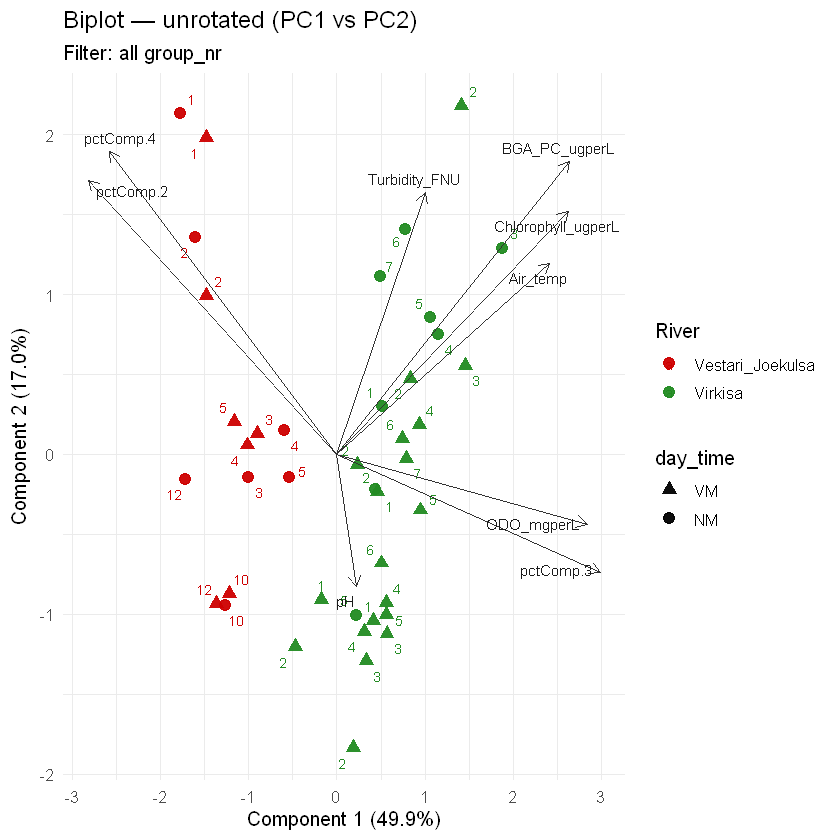

Biplots saved to: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp/biplots


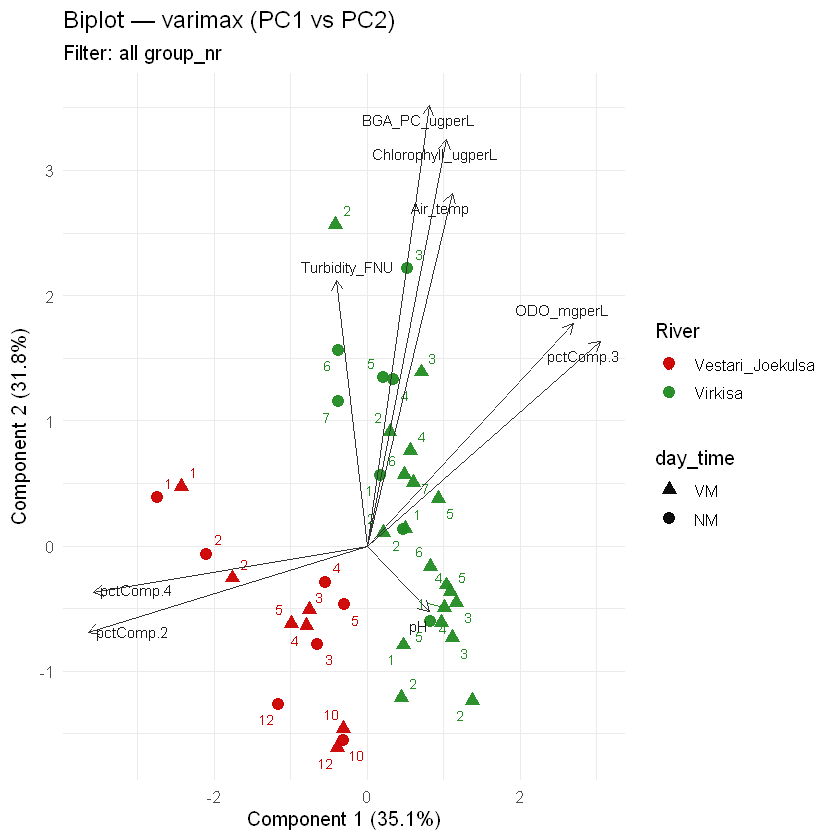

In [39]:
# ================================
# Biplots (PC1–PC2) mit day_time als Shape (VM/NM) + optionalem group_nr-Filter
# ================================
suppressPackageStartupMessages({
  library(ggplot2); library(ggrepel); library(dplyr); library(stringr); library(tidyr)
})

## ======= HIER EINSTELLEN =======
GROUP_FILTER <- "all"    # "all"  ODER z.B. 1  ODER c(1,2,3)
## ===============================

# helper: erste existierende Spalte (case-insensitive)
pick_col <- function(df, choices){
  cn <- names(df)
  for(nm in choices){
    hit <- which(tolower(cn) == tolower(nm))
    if(length(hit)) return(cn[hit[1]])
  }
  NULL
}

# nur die Zeilen, die in der PCA waren (vollständige Fälle)
row_idx <- complete.cases(dat_num)
meta <- raw[row_idx, , drop = FALSE]

# Spalten zuordnen
col_river   <- pick_col(meta, c("river_name","river_Name","river","River","Plot","plot"))
col_site    <- pick_col(meta, c("site_nr","Site","site","siteID","site_id","DOC_label"))
col_daytime <- pick_col(meta, c("day_time","Day_time","dayTime","day.time"))
col_groupnr <- pick_col(meta, c("group_nr","GroupNr","group","Group"))

# Fallbacks
if(is.null(col_river))   { meta$.__river__ <- NA_character_; col_river   <- ".__river__" }
if(is.null(col_site))    { meta$.__site__  <- seq_len(nrow(meta)); col_site <- ".__site__" }
if(is.null(col_daytime)) { meta$.__dt__    <- NA_character_; col_daytime <- ".__dt__" }
if(is.null(col_groupnr)) { meta$.__gnr__   <- NA_integer_;   col_groupnr <- ".__gnr__" }

# Werte bereinigen
river_clean <- as.character(meta[[col_river]])
river_clean <- case_when(
  str_detect(river_clean, regex("virkisa", ignore_case=TRUE)) ~ "Virkisa",
  str_detect(river_clean, regex("^vestari", ignore_case=TRUE)) ~ "Vestari_Joekulsa",
  TRUE ~ river_clean
)
site_lab <- as.character(meta[[col_site]])

# day_time → VM/NM
dt_raw <- as.character(meta[[col_daytime]])
VMNMF <- case_when(
  str_detect(dt_raw, regex("^vm$", ignore_case=TRUE)) ~ "VM",
  str_detect(dt_raw, regex("^nm$", ignore_case=TRUE)) ~ "NM",
  TRUE ~ NA_character_
)

# group_nr (optional nur zum Filtern)
GroupNr <- suppressWarnings(as.integer(meta[[col_groupnr]]))

# fehlende Werte markieren (für Levels)
river_clean[is.na(river_clean) | river_clean==""] <- "(missing)"
VMNMF[is.na(VMNMF) | VMNMF==""]                   <- "(missing)"

# Anzeige-Filter
keep_idx <- rep(TRUE, nrow(meta))
if(!identical(GROUP_FILTER, "all")){
  keep_idx <- GroupNr %in% GROUP_FILTER
  if(!any(keep_idx, na.rm=TRUE)) warning("GROUP_FILTER hat keine Treffer in group_nr.")
}

# Levels & manuelle Skalen (exakt → keine Warnungen)
river_lvls <- unique(river_clean)
vm_lvls    <- unique(VMNMF)

col_map <- setNames(rep("grey40", length(river_lvls)), river_lvls)
if("Vestari_Joekulsa" %in% river_lvls) col_map["Vestari_Joekulsa"] <- "red3"
if("Virkisa" %in% river_lvls)          col_map["Virkisa"]          <- "forestgreen"

shape_map <- setNames(rep(16, length(vm_lvls)), vm_lvls)
if("VM" %in% vm_lvls) shape_map["VM"] <- 17
if("NM" %in% vm_lvls) shape_map["NM"] <- 19

RiverF <- factor(river_clean, levels=river_lvls)
VMNMF  <- factor(VMNMF,       levels=vm_lvls)
Label  <- site_lab

# ========= Diagnose: sind VM & NM pro site vorhanden (nach Filter + CC)? =========
diag_tbl <- tibble(river=RiverF, site=Label, VMNM=VMNMF, group_nr=GroupNr) %>%
  filter(keep_idx) %>%
  count(river, site, VMNM, group_nr, name="n") %>%
  arrange(river, site, VMNM, group_nr)
cat("\n==== Presence after filter (per river/site & VM/NM & group_nr) ====\n")
print(utils::head(diag_tbl, 50))

wide_check <- diag_tbl %>%
  select(river, site, VMNM) %>% distinct() %>%
  tidyr::pivot_wider(names_from=VMNM, values_from=VMNM, values_fn=length, values_fill=0)
cat("\nSites missing VM or NM (0 indicates missing):\n")
print(utils::head(wide_check, 50))

# ========= Plot-Builder =========
make_biplot <- function(scores, loads, var_prop, title_txt, file_png){
  df_sco <- as.data.frame(scores[,1:2, drop=FALSE]); names(df_sco) <- c("PC1","PC2")
  df_sco <- df_sco[keep_idx, , drop=FALSE]
  df_sco$RiverF <- RiverF[keep_idx]
  df_sco$VMNMF  <- VMNMF [keep_idx]
  df_sco$Label  <- Label [keep_idx]

  L <- as.data.frame(loads[,1:2, drop=FALSE]); names(L) <- c("PC1","PC2"); L$var <- rownames(loads)

  # Pfeile skalieren
  rx <- diff(range(df_sco$PC1, na.rm=TRUE)); if(!is.finite(rx)||rx==0) rx <- 1
  ry <- diff(range(df_sco$PC2, na.rm=TRUE)); if(!is.finite(ry)||ry==0) ry <- 1
  maxL <- max(sqrt(L$PC1^2 + L$PC2^2), na.rm=TRUE); if(!is.finite(maxL)||maxL==0) maxL <- 1
  scf  <- 0.9 * min(rx, ry) / maxL
  Ls <- transform(L, PC1=PC1*scf, PC2=PC2*scf)

  ax1 <- paste0("Component 1 (", sprintf("%.1f", 100*var_prop[1]), "%)")
  ax2 <- paste0("Component 2 (", sprintf("%.1f", 100*var_prop[2]), "%)")
  subt <- if(identical(GROUP_FILTER,"all")) "Filter: all group_nr"
          else paste0("Filter: group_nr in {", paste(GROUP_FILTER, collapse=", "), "}")

  p <- ggplot() +
    geom_point(data=df_sco, aes(PC1,PC2, color=RiverF, shape=VMNMF), size=3, alpha=0.95) +
    ggrepel::geom_text_repel(data=df_sco, aes(PC1,PC2, label=Label, color=RiverF),
                             size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2) +
    geom_segment(data=Ls, aes(x=0,y=0,xend=PC1,yend=PC2),
                 arrow=arrow(length=unit(0.25,"cm")), linewidth=0.4, color="grey20") +
    ggrepel::geom_text_repel(data=Ls, aes(PC1,PC2,label=var),
                             size=3.2, color="grey10", max.overlaps=Inf, box.padding=0.25) +
    scale_color_manual(values=col_map, breaks=names(col_map), drop=FALSE) +
    scale_shape_manual(values=shape_map, breaks=names(shape_map), drop=FALSE) +
    labs(title=title_txt, subtitle=subt, x=ax1, y=ax2, color="River", shape="day_time") +
    theme_minimal(base_size=12) + theme(legend.position="right")

  print(p)
  ggsave(file_png, p, width=20, height=16, units="cm", dpi=300)
}

# ========= Ausgabe =========
biplot_dir <- file.path(out_dir, "biplots")
if(!dir.exists(biplot_dir)) dir.create(biplot_dir, recursive=TRUE)

if(!is.null(pca_unrot) && !is.null(pca_rot) && ncol(as.data.frame(pca_unrot$scores)) >= 2){
  # UNROTATED
  scr_un <- as.data.frame(pca_unrot$scores)
  lod_un <- as.matrix(unclass(pca_unrot$loadings))
  var_un <- as.numeric(pca_unrot$Vaccounted["Proportion Var", 1:2])
  make_biplot(scr_un, lod_un, var_un,
              "Biplot — unrotated (PC1 vs PC2)",
              file.path(biplot_dir, if(identical(GROUP_FILTER,"all")) "Biplot_unrotated_PC1_PC2_all.png" else "Biplot_unrotated_PC1_PC2_filtered.png"))

  # VARIMAX
  scr_ro <- as.data.frame(pca_rot$scores)
  lod_ro <- as.matrix(unclass(pca_rot$loadings))
  var_ro <- as.numeric(pca_rot$Vaccounted["Proportion Var", 1:2])
  make_biplot(scr_ro, lod_ro, var_ro,
              "Biplot — varimax (PC1 vs PC2)",
              file.path(biplot_dir, if(identical(GROUP_FILTER,"all")) "Biplot_varimax_PC1_PC2_all.png" else "Biplot_varimax_PC1_PC2_filtered.png"))
}

cat("Biplots saved to: ", biplot_dir, "\n", sep="")


# alle Biplots

In [40]:
# ================================
# SAVE-ONLY: custom biplots (unrotated & varimax) + grids
# ================================
suppressPackageStartupMessages({
  library(ggplot2); library(ggrepel); library(dplyr); library(stringr); library(patchwork)
})

## ---- optionaler Anzeige-Filter über group_nr (nur für Plots) ----
GROUP_FILTER <- "all"   # "all" ODER numerisch: 1  ODER c(1,2)

# helper
pick_col <- function(df, choices){
  cn <- names(df)
  for(nm in choices){
    hit <- which(tolower(cn) == tolower(nm))
    if(length(hit)) return(cn[hit[1]])
  }
  NULL
}

# nur vollständige Fälle wie in der PCA
row_idx <- complete.cases(dat_num)
meta <- raw[row_idx, , drop = FALSE]

# Spalten finden
col_river   <- pick_col(meta, c("river_name","river_Name","river","River","Plot","plot"))
col_site    <- pick_col(meta, c("site_nr","Site","site","siteID","site_id","DOC_label"))
col_daytime <- pick_col(meta, c("day_time","Day_time","dayTime","day.time"))
col_groupnr <- pick_col(meta, c("group_nr","GroupNr","group","Group"))

# Fallbacks
if(is.null(col_river))   { meta$.__river__ <- NA_character_; col_river   <- ".__river__" }
if(is.null(col_site))    { meta$.__site__  <- seq_len(nrow(meta)); col_site <- ".__site__" }
if(is.null(col_daytime)) { meta$.__dt__    <- NA_character_; col_daytime <- ".__dt__" }
if(is.null(col_groupnr)) { meta$.__gnr__   <- NA_integer_;   col_groupnr <- ".__gnr__" }

# Werte bereinigen
river_clean <- as.character(meta[[col_river]])
river_clean <- dplyr::case_when(
  str_detect(river_clean, regex("virkisa", ignore_case=TRUE)) ~ "Virkisa",
  str_detect(river_clean, regex("^vestari", ignore_case=TRUE)) ~ "Vestari_Joekulsa",
  TRUE ~ river_clean
)
site_lab <- as.character(meta[[col_site]])

dt_raw <- as.character(meta[[col_daytime]])
VMNMF  <- dplyr::case_when(
  str_detect(dt_raw, regex("^vm$", ignore_case=TRUE)) ~ "VM",
  str_detect(dt_raw, regex("^nm$", ignore_case=TRUE)) ~ "NM",
  TRUE ~ NA_character_
)

GroupNr <- suppressWarnings(as.integer(meta[[col_groupnr]]))

river_clean[is.na(river_clean)|river_clean==""] <- "(missing)"
VMNMF[is.na(VMNMF)|VMNMF==""]                   <- "(missing)"

# Filter
keep_idx <- rep(TRUE, nrow(meta))
if(!identical(GROUP_FILTER,"all")){
  keep_idx <- GroupNr %in% GROUP_FILTER
}

# Levels & Skalen
river_lvls <- unique(river_clean); vm_lvls <- unique(VMNMF)
col_map <- setNames(rep("grey40", length(river_lvls)), river_lvls)
if("Vestari_Joekulsa" %in% river_lvls) col_map["Vestari_Joekulsa"] <- "red3"
if("Virkisa" %in% river_lvls)          col_map["Virkisa"]          <- "forestgreen"
shape_map <- setNames(rep(16, length(vm_lvls)), vm_lvls)
if("VM" %in% vm_lvls) shape_map["VM"] <- 17
if("NM" %in% vm_lvls) shape_map["NM"] <- 19

RiverF <- factor(river_clean, levels=river_lvls)
VMNMF  <- factor(VMNMF,       levels=vm_lvls)
Label  <- site_lab

# Ordner
dir_unrot <- file.path(out_dir, "biplots", "custom_unrotated")
dir_rot   <- file.path(out_dir, "biplots", "custom_rotated")
dir_grid  <- file.path(out_dir, "biplots", "grid")
dir.create(dir_unrot, showWarnings=FALSE, recursive=TRUE)
dir.create(dir_rot,   showWarnings=FALSE, recursive=TRUE)
dir.create(dir_grid,  showWarnings=FALSE, recursive=TRUE)

# Generischer Biplot-Builder
make_custom_biplot <- function(pca_obj, i=1, j=2, tag="unrotated"){
  scores <- as.data.frame(pca_obj$scores)
  loads  <- as.matrix(unclass(pca_obj$loadings))
  var_p  <- as.numeric(pca_obj$Vaccounted["Proportion Var", 1:ncol(loads)])

  df_sco <- scores[keep_idx, c(i,j), drop=FALSE]
  names(df_sco) <- c("x","y")
  df_sco$RiverF <- RiverF[keep_idx]
  df_sco$VMNMF  <- VMNMF [keep_idx]
  df_sco$Label  <- Label [keep_idx]

  L <- as.data.frame(loads[, c(i,j), drop=FALSE]); names(L) <- c("x","y"); L$var <- rownames(loads)

  # Pfeile skalieren
  rx <- diff(range(df_sco$x, na.rm=TRUE)); if(!is.finite(rx)||rx==0) rx <- 1
  ry <- diff(range(df_sco$y, na.rm=TRUE)); if(!is.finite(ry)||ry==0) ry <- 1
  maxL <- max(sqrt(L$x^2 + L$y^2), na.rm=TRUE); if(!is.finite(maxL)||maxL==0) maxL <- 1
  scf  <- 0.9 * min(rx, ry) / maxL
  Ls   <- transform(L, x=x*scf, y=y*scf)

  ax_x <- paste0("Component ", i, " (", sprintf("%.1f", 100*var_p[i]), "%)")
  ax_y <- paste0("Component ", j, " (", sprintf("%.1f", 100*var_p[j]), "%)")
  subt <- if(identical(GROUP_FILTER,"all")) "Displayed: all group_nr"
          else paste0("Displayed group_nr in {", paste(GROUP_FILTER, collapse=", "), "}")

  ggplot() +
    geom_point(data=df_sco, aes(x, y, color=RiverF, shape=VMNMF), size=3, alpha=0.95) +
    ggrepel::geom_text_repel(data=df_sco, aes(x, y, label=Label, color=RiverF),
                             size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2) +
    geom_segment(data=Ls, aes(x=0, y=0, xend=x, yend=y),
                 arrow=arrow(length=unit(0.25,"cm")), linewidth=0.4, color="grey20") +
    ggrepel::geom_text_repel(data=Ls, aes(x, y, label=var),
                             size=3.2, color="grey10", max.overlaps=Inf, box.padding=0.25) +
    scale_color_manual(values=col_map, breaks=names(col_map), drop=FALSE) +
    scale_shape_manual(values=shape_map, breaks=names(shape_map), drop=FALSE) +
    labs(title=paste0("Colored biplot — ", tag, " (PC",i," vs PC",j,")"),
         subtitle=subt, x=ax_x, y=ax_y, color="River", shape="day_time") +
    theme_minimal(base_size=12) + theme(legend.position="right")
}

# Alle Paare bauen & speichern + Grid erstellen (ohne print())
save_set <- function(pca_obj, tag=c("unrotated","varimax")){
  tag <- match.arg(tag)
  dir_out <- if(tag=="unrotated") dir_unrot else dir_rot

  maxc <- min(ncol(as.data.frame(pca_obj$scores)),
              ncol(as.data.frame(unclass(pca_obj$loadings))))
  pairs <- list(c(1,2))
  if(maxc >= 3) pairs <- c(pairs, list(c(1,3), c(2,3)))

  plist <- list()
  for(pr in pairs){
    i <- pr[1]; j <- pr[2]
    p <- make_custom_biplot(pca_obj, i=i, j=j, tag=tag)
    plist[[paste0("PC",i,"PC",j)]] <- p
    ggsave(file.path(dir_out, paste0("Custom_", tag, "_PC",i,"_PC",j,".png")),
           p, width=22, height=18, units="cm", dpi=300)
  }

  # Grid (2x3 oder 1x3), Annotation ohne Sonderzeichen
  grid <- if(length(plist)==1) plist[[1]] else
          if(length(plist)==2) plist[[1]] | plist[[2]] else
          (plist[[1]] | plist[[2]] | plist[[3]])

  grid <- grid + plot_annotation(
    title    = paste0("Summary grid — ", tag),
    subtitle = "Points = sample scores (color by river, shape by day_time: VM triangle, NM circle). Arrows = variable loadings.",
    caption  = "Axes show principal components with explained variance (%)"
  )

  ggsave(file.path(dir_grid, paste0("CustomGrid_", tag, ".png")),
         grid, width=44, height=26, units="cm", dpi=300)
}

# speichern (ohne Anzeige)
save_set(pca_unrot, "unrotated")
save_set(pca_rot,   "varimax")

cat("Saved to:\n- ", dir_unrot, "\n- ", dir_rot, "\n- ", dir_grid, "\n", sep="")


Saved to:
- C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp/biplots/custom_unrotated
- C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp/biplots/custom_rotated
- C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp/biplots/grid


# psychgrid

In [41]:
# ================================
# Psych PCA biplot grid mit sauberen globalen Achsenlabels
# ================================
suppressPackageStartupMessages({ library(psych) })

dir_psych <- file.path(out_dir, "biplots", "psych_grid_labeled_clean")
dir.create(dir_psych, showWarnings = FALSE, recursive = TRUE)

pc_labels <- function(pca){
  va <- as.numeric(pca$Vaccounted["Proportion Var", ])
  fmt <- function(x) sprintf("%.1f%%", 100*x)
  paste0("PC", seq_along(va), " (", fmt(va), ")")
}

save_psych_grid_labeled <- function(pca_obj, main_title, file_png){
  png(file_png, width=2200, height=1800, res=180)
  op <- par(oma=c(8,8,4,2))  # mehr Platz außen
  on.exit({ par(op); dev.off() }, add=TRUE)

  biplot.psych(pca_obj, main=main_title)

  labs <- pc_labels(pca_obj)

  # X-Achse: gerade Reihenfolge
  mtext(paste( paste(labs, collapse="                            |                         ")),
        side=1, line=9, adj=0.5, cex=1.0, col="black")

  # Y-Achse: umgekehrte Reihenfolge
  mtext(paste(paste(rev(labs), collapse="                    |                 ")),
        side=2, line=7, adj=0.5, cex=1.0, col="black")
}

# Unrotated
save_psych_grid_labeled(pca_unrot, "PCA biplot grid — unrotated",
                        file.path(dir_psych, "PsychGrid_unrotated_labeled.png"))

# Varimax
save_psych_grid_labeled(pca_rot, "PCA biplot grid — varimax",
                        file.path(dir_psych, "PsychGrid_varimax_labeled.png"))

cat("Psych grids mit sauberen Labels gespeichert in: ", dir_psych, "\n", sep="")


Psych grids mit sauberen Labels gespeichert in: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp/biplots/psych_grid_labeled_clean


# tables 


In [42]:
# ================================
# EXTRA: Tables in document style (communalities, loadings, variance explained)
# ================================

# Communalities table
show_h1("Communalities (Initial=1, Extraction from PCA)")
comm_tab <- data.frame(
  Variable   = commu_unrot$Variable,
  Initial    = 1.000,
  Extraction = round(commu_unrot$Communality, 6)
)
show_tbl(comm_tab, "Communalities")
write.csv(comm_tab, file.path(out_dir,"40_Communalities.csv"), row.names=FALSE)

# Component matrix (unrotated)
show_h1("Component matrix — unrotated")
comp_mat_unrot <- round(as.data.frame(unclass(pca_unrot$loadings)[,1:ncomp, drop=FALSE]), 3)
colnames(comp_mat_unrot) <- paste0("Component ", seq_len(ncomp))
comp_mat_unrot <- tibble::rownames_to_column(comp_mat_unrot, "Variable")
show_tbl(comp_mat_unrot, "Component loadings (unrotated)")
write.csv(comp_mat_unrot, file.path(out_dir,"41_ComponentMatrix_unrotated.csv"), row.names=FALSE)

# Component matrix (unrotated, sorted by |loading| ≥ LOAD_THRESH)
show_h1(sprintf("Component matrix — unrotated (|loading| ≥ %.2f)", LOAD_THRESH))
ass_unrot <- comp_mat_unrot
ass_unrot[,-1] <- lapply(ass_unrot[,-1], function(x) ifelse(abs(x) >= LOAD_THRESH, x, NA))
show_tbl(ass_unrot, "Variables assigned (unrotated)")
write.csv(ass_unrot, file.path(out_dir,"42_ComponentMatrix_unrotated_threshold.csv"), row.names=FALSE)

# Component matrix (varimax, sorted by |loading| ≥ LOAD_THRESH)
show_h1(sprintf("Component matrix — varimax (|loading| ≥ %.2f)", LOAD_THRESH))
comp_mat_rot <- round(as.data.frame(unclass(pca_rot$loadings)[,1:ncomp, drop=FALSE]), 3)
colnames(comp_mat_rot) <- paste0("Component ", seq_len(ncomp))
comp_mat_rot <- tibble::rownames_to_column(comp_mat_rot, "Variable")
ass_rot <- comp_mat_rot
ass_rot[,-1] <- lapply(ass_rot[,-1], function(x) ifelse(abs(x) >= LOAD_THRESH, x, NA))
show_tbl(ass_rot, "Variables assigned (varimax)")
write.csv(ass_rot, file.path(out_dir,"43_ComponentMatrix_varimax_threshold.csv"), row.names=FALSE)

# Variance explained
show_h1("Variance explained (unrotated & varimax)")
var_tab <- data.frame(
  Component = paste0("PC", seq_len(ncomp)),
  Eigenvalue_unrot = round(pca_unrot$values[1:ncomp],3),
  PropVar_unrot    = round(pca_unrot$Vaccounted["Proportion Var",1:ncomp],3),
  CumVar_unrot     = round(pca_unrot$Vaccounted["Cumulative Var",1:ncomp],3),
  Eigenvalue_rot   = round(pca_rot$values[1:ncomp],3),
  PropVar_rot      = round(pca_rot$Vaccounted["Proportion Var",1:ncomp],3),
  CumVar_rot       = round(pca_rot$Vaccounted["Cumulative Var",1:ncomp],3)
)
show_tbl(var_tab, "Variance explained")
write.csv(var_tab, file.path(out_dir,"44_Variance_explained.csv"), row.names=FALSE)




==== Communalities (Initial=1, Extraction from PCA) ====


Table: Communalities

Variable             Initial   Extraction 
-------------------  --------  -----------
Chlorophyll_ugperL   1         0.789579   
ODO_mgperL           1         0.707842   
BGA_PC_ugperL        1         0.885890   
Turbidity_FNU        1         0.317200   
pH                   1         0.063203   
pctComp.2            1         0.933459   
pctComp.3            1         0.811675   
pctComp.4            1         0.880894   
Air_temp             1         0.622716   


==== Component matrix — unrotated ====


Table: Component loadings (unrotated)

Variable             Component 1   Component 2 
-------------------  ------------  ------------
Chlorophyll_ugperL   0.769         0.446       
ODO_mgperL           0.831         -0.128      
BGA_PC_ugperL        0.773         0.538       
Turbidity_FNU        0.294         0.481       
pH                   0.064         -0.243      
pctComp.2            -0.82

# Elipse

In [43]:
# ================================
# Biplots mit Ellipsen (zusätzlich zu Farbe=River, Shape=day_time)
# ================================
suppressPackageStartupMessages({
  req <- c("ggplot2","ggrepel","dplyr","stringr","ggnewscale")
  to_install <- req[!req %in% rownames(installed.packages())]
  if(length(to_install)) install.packages(to_install, quiet = TRUE)
  lapply(req, library, character.only = TRUE)
})

## ======= HIER EINSTELLEN =======
ELLIPSE_BY    <- "group_nr"  # <<< "group_nr" | "day_time" | "river"
ELLIPSE_LEVEL <- 0.95        # Konfidenzniveau der Ellipse (z.B. 0.68, 0.95)
GROUP_FILTER  <- "all"       # Anzeige-Filter über group_nr: "all" oder z.B. 1, c(1,2)
## ===============================

# --- kleine Helfer ---
pick_col <- function(df, choices){
  cn <- names(df); for(nm in choices){
    hit <- which(tolower(cn) == tolower(nm)); if(length(hit)) return(cn[hit[1]])
  }; NULL
}

# Zeilen wie in der PCA (complete cases)
row_idx <- complete.cases(dat_num)
meta <- raw[row_idx, , drop = FALSE]

# Spalten finden
col_river   <- pick_col(meta, c("river_name","river_Name","river","River","Plot","plot"))
col_site    <- pick_col(meta, c("site_nr","Site","site","siteID","site_id","DOC_label"))
col_daytime <- pick_col(meta, c("day_time","Day_time","dayTime","day.time"))
col_groupnr <- pick_col(meta, c("group_nr","GroupNr","group","Group"))

# Fallbacks
if(is.null(col_river))   { meta$.__river__ <- NA_character_; col_river   <- ".__river__" }
if(is.null(col_site))    { meta$.__site__  <- seq_len(nrow(meta)); col_site <- ".__site__" }
if(is.null(col_daytime)) { meta$.__dt__    <- NA_character_; col_daytime <- ".__dt__" }
if(is.null(col_groupnr)) { meta$.__gnr__   <- NA_integer_;   col_groupnr <- ".__gnr__" }

# Werte bereinigen / Faktoren bauen
river_raw <- as.character(meta[[col_river]])
river_clean <- dplyr::case_when(
  str_detect(river_raw, regex("virkisa", ignore_case=TRUE)) ~ "Virkisa",
  str_detect(river_raw, regex("^vestari", ignore_case=TRUE)) ~ "Vestari_Joekulsa",
  TRUE ~ river_raw
)
site_lab <- as.character(meta[[col_site]])

dt_raw <- as.character(meta[[col_daytime]])
VMNMF <- dplyr::case_when(
  str_detect(dt_raw, regex("^vm$", ignore_case=TRUE)) ~ "VM",
  str_detect(dt_raw, regex("^nm$", ignore_case=TRUE)) ~ "NM",
  TRUE ~ NA_character_
)

GroupNr <- suppressWarnings(as.integer(meta[[col_groupnr]]))

river_clean[is.na(river_clean) | river_clean==""] <- "(missing)"
VMNMF[is.na(VMNMF) | VMNMF==""]                   <- "(missing)"

# Anzeige-Filter (nur für Plots)
keep_idx <- rep(TRUE, nrow(meta))
if(!identical(GROUP_FILTER,"all")){
  keep_idx <- GroupNr %in% GROUP_FILTER
}

# Punkt-Skalen (River-Farbe, day_time-Shape)
river_lvls <- unique(river_clean); vm_lvls <- unique(VMNMF)
col_map <- setNames(rep("grey40", length(river_lvls)), river_lvls)
if("Vestari_Joekulsa" %in% river_lvls) col_map["Vestari_Joekulsa"] <- "red3"
if("Virkisa" %in% river_lvls)          col_map["Virkisa"]          <- "forestgreen"
shape_map <- setNames(rep(16, length(vm_lvls)), vm_lvls)
if("VM" %in% vm_lvls) shape_map["VM"] <- 17
if("NM" %in% vm_lvls) shape_map["NM"] <- 19

RiverF <- factor(river_clean, levels=river_lvls)
VMNMF  <- factor(VMNMF,       levels=vm_lvls)
Label  <- site_lab

# Ellipsen-Gruppierung (leicht umstellbar)
ellipse_factor <- function(){
  if(ELLIPSE_BY == "group_nr"){
    f <- factor(GroupNr[keep_idx])
    levels(f) <- paste0("G", levels(f))   # hübschere Labels
    list(f=f, name="Ellipse: group_nr")
  } else if(ELLIPSE_BY == "day_time"){
    list(f = factor(VMNMF[keep_idx], levels=vm_lvls), name="Ellipse: day_time")
  } else { # "river"
    list(f = factor(RiverF[keep_idx], levels=river_lvls), name="Ellipse: river")
  }
}

# Ausgabepfade
dir_unrot <- file.path(out_dir, "biplots", "ellipses_unrotated")
dir_rot   <- file.path(out_dir, "biplots", "ellipses_rotated")
dir.create(dir_unrot, showWarnings=FALSE, recursive=TRUE)
dir.create(dir_rot,   showWarnings=FALSE, recursive=TRUE)

# --------- Plot-Builder (PC i vs j) mit Ellipse ----------
make_biplot_ellipse <- function(pca_obj, i=1, j=2, tag="unrotated", file_png){
  scores <- as.data.frame(pca_obj$scores)
  loads  <- as.matrix(unclass(pca_obj$loadings))
  var_p  <- as.numeric(pca_obj$Vaccounted["Proportion Var", 1:ncol(loads)])

  df_sco <- scores[keep_idx, c(i,j), drop=FALSE]; names(df_sco) <- c("x","y")
  df_sco$RiverF <- RiverF[keep_idx]
  df_sco$VMNMF  <- VMNMF [keep_idx]
  df_sco$Label  <- Label [keep_idx]

  L <- as.data.frame(loads[, c(i,j), drop=FALSE]); names(L) <- c("x","y"); L$var <- rownames(loads)

  # Pfeile skalieren
  rx <- diff(range(df_sco$x, na.rm=TRUE)); if(!is.finite(rx)||rx==0) rx <- 1
  ry <- diff(range(df_sco$y, na.rm=TRUE)); if(!is.finite(ry)||ry==0) ry <- 1
  maxL <- max(sqrt(L$x^2 + L$y^2), na.rm=TRUE); if(!is.finite(maxL)||maxL==0) maxL <- 1
  scf  <- 0.9 * min(rx, ry) / maxL
  Ls   <- transform(L, x=x*scf, y=y*scf)

  ax_x <- paste0("Component ", i, " (", sprintf("%.1f", 100*var_p[i]), "%)")
  ax_y <- paste0("Component ", j, " (", sprintf("%.1f", 100*var_p[j]), "%)")
  subt <- if(identical(GROUP_FILTER,"all")) "Displayed: all group_nr"
          else paste0("Displayed group_nr in {", paste(GROUP_FILTER, collapse=", "), "}")

  # Ellipse-Faktor + Farben dafür (zweite Farbskala)
  ef <- ellipse_factor()
  ell_lvls <- levels(ef$f)
  ell_cols <- setNames(scales::hue_pal()(length(ell_lvls)), ell_lvls)

  p <- ggplot() +
    # 1) Punkte (Farbe=River, Shape=day_time)
    geom_point(data=df_sco, aes(x, y, color=RiverF, shape=VMNMF), size=3, alpha=0.95) +
    ggrepel::geom_text_repel(data=df_sco, aes(x, y, label=Label, color=RiverF),
                             size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2) +
    # 2) Variablenpfeile
    geom_segment(data=Ls, aes(x=0, y=0, xend=x, yend=y),
                 arrow=arrow(length=unit(0.25,"cm")), linewidth=0.4, color="grey20") +
    ggrepel::geom_text_repel(data=Ls, aes(x, y, label=var),
                             size=3.2, color="grey10", max.overlaps=Inf, box.padding=0.25) +
    # Skalen für Punkte
    scale_color_manual(values=col_map, breaks=names(col_map), drop=FALSE) +
    scale_shape_manual(values=shape_map, breaks=names(shape_map), drop=FALSE) +
    labs(title=paste0("Biplot + ellipse — ", tag, " (PC",i," vs PC",j,")"),
         subtitle=subt, x=ax_x, y=ax_y, color="River", shape="day_time") +
    theme_minimal(base_size=12) + theme(legend.position="right")

  # 3) Zweite Farbskala für Ellipsen (unabhängig von River-Farben)
  p <- p + ggnewscale::new_scale_colour() +
    stat_ellipse(data = transform(df_sco, EllF = ef$f),
                 aes(x, y, colour = EllF),
                 type = "norm", level = ELLIPSE_LEVEL,
                 linewidth = 0.9, alpha = 0.95, inherit.aes = FALSE) +
    scale_colour_manual(values = ell_cols, name = ef$name)

  # speichern (nicht anzeigen)
  ggsave(file_png, p, width=22, height=18, units="cm", dpi=300)
}

# --------- komplette Sets speichern ---------
save_ellipse_set <- function(pca_obj, tag=c("unrotated","varimax")){
  tag <- match.arg(tag)
  dir_out <- if(tag=="unrotated") dir_unrot else dir_rot

  maxc <- min(ncol(as.data.frame(pca_obj$scores)),
              ncol(as.data.frame(unclass(pca_obj$loadings))))
  pairs <- list(c(1,2))
  if(maxc >= 3) pairs <- c(pairs, list(c(1,3), c(2,3)))

  for(pr in pairs){
    i <- pr[1]; j <- pr[2]
    fn <- file.path(dir_out, paste0("Biplot_", tag, "_ellipse_", ELLIPSE_BY,
                                    "_PC",i,"_PC",j,".png"))
    make_biplot_ellipse(pca_obj, i=i, j=j, tag=tag, file_png=fn)
  }
}

# unrotated + varimax speichern
save_ellipse_set(pca_unrot, "unrotated")
save_ellipse_set(pca_rot,   "varimax")

cat("Ellipse-Biplots gespeichert in:\n- ", dir_unrot, "\n- ", dir_rot, "\n", sep="")


[[1]]
 [1] "ggnewscale"  "patchwork"   "tidyr"       "stringr"     "grid"       
 [6] "factoextra"  "Matrix"      "ggrepel"     "GPArotation" "knitr"      
[11] "tibble"      "corrplot"    "ggplot2"     "dplyr"       "psych"      
[16] "readxl"      "stats"       "graphics"    "grDevices"   "utils"      
[21] "datasets"    "methods"     "base"       

[[2]]
 [1] "ggnewscale"  "patchwork"   "tidyr"       "stringr"     "grid"       
 [6] "factoextra"  "Matrix"      "ggrepel"     "GPArotation" "knitr"      
[11] "tibble"      "corrplot"    "ggplot2"     "dplyr"       "psych"      
[16] "readxl"      "stats"       "graphics"    "grDevices"   "utils"      
[21] "datasets"    "methods"     "base"       

[[3]]
 [1] "ggnewscale"  "patchwork"   "tidyr"       "stringr"     "grid"       
 [6] "factoextra"  "Matrix"      "ggrepel"     "GPArotation" "knitr"      
[11] "tibble"      "corrplot"    "ggplot2"     "dplyr"       "psych"      
[16] "readxl"      "stats"       "graphics"    "grDevices"   "utils"      
[21] "datasets"    "methods"     "base"       

[[4]]
 [1] "ggnewscale"  "patchwork"   "tidyr"       "stringr"     "grid"       
 [6] "factoextra"  "Matrix"      "ggrepel"     "GPArotation" "knitr"      
[11] "tibble"      "corrplot"    "ggplot2"     "dplyr"       "psych"      
[16] "readxl"      "stats"       "graphics"    "grDevices"   "utils"      
[21] "datasets"    "methods"     "base"       

[[5]]
 [1] "ggnewscale"  "patchwork"   "tidyr"       "stringr"     "grid"       
 [6] "factoextra"  "Matrix"      "ggrepel"     "GPArotation" "knitr"      
[11] "tibble"      "corrplot"    "ggplot2"     "dplyr"       "psych"      
[16] "readxl"      "stats"       "graphics"    "grDevices"   "utils"      
[21] "datasets"    "methods"     "base"

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Warning message:
"Removed 2 rows containing missing values or values outside the scale range (`geom_path()`)."
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Warning message:
"Removed 2 rows containing missing values or values outside the scale range (`geom_path()`)."


Ellipse-Biplots gespeichert in:
- C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp/biplots/ellipses_unrotated
- C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp/biplots/ellipses_rotated


# einfärbungn nach menge


In [44]:

#ELLIPSE_INCLUDE <- c(1,2,3,4,5)             # nur diese Wochen berücksichtigen
#ELLIPSE_GROUPS  <- list("G1"=1, "G2-5"=2:5)  # zusammenfassen
#ELLIPSE_MIN_N   <- 3                         # mind. 3 Punkte je Ellipse

In [45]:
# ================================
# Biplots: beide Flüsse + DOC-Skalen + Ellipsen mit flexibler Gruppierung
# ================================
suppressPackageStartupMessages({
  req <- c("ggplot2","ggrepel","dplyr","stringr","ggnewscale")
  to_install <- req[!req %in% rownames(installed.packages())]
  if(length(to_install)) install.packages(to_install, quiet = TRUE)
  invisible(lapply(req, library, character.only = TRUE))
})

## ======= HIER EINSTELLEN (Ellipsen-Steuerung) =======
ELLIPSE_LEVEL   <- 0.95        # 0.68, 0.95, 0.99 …
ELLIPSE_MIN_N   <- 3           # min. Punkte je (evtl. zusammengefasster) Gruppe
ELLIPSE_INCLUDE <- "all"       # "all" ODER Vektor z.B. c(1,2,3) -> nur diese group_nr
# Gruppen zusammenfassen (Namen = Legendenlabel, Werte = Vektor von group_nr)
# Beispiel: nur G1 sowie G2-5 zusammen:
ELLIPSE_GROUPS <- list("G1"=1, "G2-5"=2:5)
#ELLIPSE_GROUPS  <- NULL        # NULL = keine Zusammenfassung


## ================================================

## ======= HIER EINSTELLEN (Punktfarben/ DOC) =====
DOC_COLOR_MODE <- "gradient"   # "gradient" ODER "threshold"
# Cutoffs (nur für "threshold"); NA = Median je Fluss
DOC_CUTOFFS <- list(Vestari_Joekulsa = NA_real_, Virkisa = NA_real_)
## ================================================







# --- helpers ---
pick_col <- function(df, choices){
  cn <- names(df); for(nm in choices){
    hit <- which(tolower(cn) == tolower(nm)); if(length(hit)) return(cn[hit[1]])
  }; NULL
}

# Daten wie in der PCA (complete cases)
row_idx <- complete.cases(dat_num)
meta <- raw[row_idx, , drop = FALSE]

# Spalten lokalisieren
col_river   <- pick_col(meta, c("river_name","river_Name","river","River","Plot","plot"))
col_site    <- pick_col(meta, c("site_nr","Site","site","siteID","site_id","DOC_label"))
col_daytime <- pick_col(meta, c("day_time","Day_time","dayTime","day.time"))
col_groupnr <- pick_col(meta, c("group_nr","GroupNr","group","Group"))
col_doc     <- pick_col(meta, c("average_DOC_sample","DOC","doc"))
stopifnot("DOC-Spalte nicht gefunden." = !is.null(col_doc))

# Werte bereinigen
river0 <- as.character(meta[[col_river]])
river  <- dplyr::case_when(
  stringr::str_detect(river0, regex("virkisa", ignore_case=TRUE)) ~ "Virkisa",
  stringr::str_detect(river0, regex("^vestari", ignore_case=TRUE)) ~ "Vestari_Joekulsa",
  TRUE ~ river0
)
site   <- as.character(meta[[col_site]])
dt0    <- as.character(meta[[col_daytime]])
VMNM   <- dplyr::case_when(
  stringr::str_detect(dt0, regex("^vm$", ignore_case=TRUE)) ~ "VM",
  stringr::str_detect(dt0, regex("^nm$", ignore_case=TRUE)) ~ "NM",
  TRUE ~ NA_character_
)
grp    <- suppressWarnings(as.integer(meta[[col_groupnr]]))
DOC    <- suppressWarnings(as.numeric(meta[[col_doc]]))
VMNM[is.na(VMNM)|VMNM==""] <- "(missing)"

# Shapes für VM/NM
shape_map <- c("VM"=17, "NM"=19, "(missing)"=16)
shape_map <- shape_map[names(shape_map) %in% unique(VMNM)]

# Ausgabe-Ordner
dir_out <- file.path(out_dir, "biplots", "ellipses_bothrivers")
dir.create(dir_out, showWarnings = FALSE, recursive = TRUE)

# ---- Ellipsen-Faktor aus group_nr nach Regeln oben bauen ----
make_EllF <- function(grp_vec){
  g <- grp_vec
  # 1) include-Filter
  if(!identical(ELLIPSE_INCLUDE, "all")){
    g[!(g %in% ELLIPSE_INCLUDE)] <- NA_integer_
  }
  # 2) Zusammenfassen
  if(is.null(ELLIPSE_GROUPS)){
    # Eigene Levels aus sortierten, vorhandenen Werten
    out <- factor(g)
    if(!identical(ELLIPSE_INCLUDE, "all")){
      # hübschere Labels z.B. "G1"
      lv <- levels(out)
      levels(out) <- paste0("G", lv)
    }
    return(out)
  } else {
    lab <- rep(NA_character_, length(g))
    for(nm in names(ELLIPSE_GROUPS)){
      lab[g %in% ELLIPSE_GROUPS[[nm]]] <- nm
    }
    return(factor(lab))
  }
}

# ---------- Plot (PC i vs j) für beide Flüsse in EINEM Bild ----------
plot_pair_bothrivers <- function(pca_obj, i=1, j=2, tag="unrotated"){
  # Scores/Loadings
  S <- as.data.frame(pca_obj$scores)[, c(i,j), drop=FALSE]; names(S) <- c("x","y")
  S$river <- river; S$site <- site; S$VMNM <- factor(VMNM, levels=unique(VMNM))
  S$grp   <- grp;   S$DOC  <- DOC
  S$EllF  <- make_EllF(S$grp)

  # Ellipsen: nur Gruppen mit ≥ ELLIPSE_MIN_N
  if(all(is.na(S$EllF))){
    ELL <- S[0,]
  } else {
    tab <- table(S$EllF, useNA="no")
    keep_lvls <- names(tab)[tab >= ELLIPSE_MIN_N]
    ELL <- dplyr::filter(S, !is.na(EllF) & EllF %in% keep_lvls)
    S$EllF[!(S$EllF %in% keep_lvls)] <- NA  # für Legende sauber
  }

  # Loadings skalieren
  L <- as.matrix(unclass(pca_obj$loadings))[, c(i,j), drop=FALSE]
  L <- data.frame(x=L[,1], y=L[,2], var=rownames(L))
  rx <- diff(range(S$x, na.rm=TRUE)); if(!is.finite(rx)||rx==0) rx <- 1
  ry <- diff(range(S$y, na.rm=TRUE)); if(!is.finite(ry)||ry==0) ry <- 1
  maxL <- max(sqrt(L$x^2 + L$y^2), na.rm=TRUE); if(!is.finite(maxL)||maxL==0) maxL <- 1
  scf  <- 0.9 * min(rx, ry) / maxL
  Ls   <- transform(L, x=x*scf, y=y*scf)

  var_p <- as.numeric(pca_obj$Vaccounted["Proportion Var", 1:ncol(unclass(pca_obj$loadings))])
  axx <- paste0("Component ", i, " (", sprintf("%.1f", 100*var_p[i]), "%)")
  axy <- paste0("Component ", j, " (", sprintf("%.1f", 100*var_p[j]), "%)")

  # Flussteile
  SV  <- dplyr::filter(S, river=="Vestari_Joekulsa")
  SVi <- dplyr::filter(S, river=="Virkisa")

  p <- ggplot() +
    # Variablenpfeile
    geom_segment(data=Ls, aes(x=0,y=0,xend=x,yend=y),
                 arrow = arrow(length=unit(0.25,"cm")), linewidth=0.4, color="grey20") +
    ggrepel::geom_text_repel(data=Ls, aes(x,y,label=var),
                             size=3.2, color="grey10", max.overlaps=Inf, box.padding=0.25) +
    scale_shape_manual(values=shape_map, name="day_time") +
    labs(title=paste0("Biplot — both rivers (", tag, ") · PC",i," vs PC",j),
         subtitle=paste0(
           "Ellipses: ", if(!is.null(ELLIPSE_GROUPS)) paste(names(ELLIPSE_GROUPS), collapse=", ") else
             if(identical(ELLIPSE_INCLUDE,"all")) "group_nr (all)" else paste0("group_nr ∈ {", paste(ELLIPSE_INCLUDE, collapse=", "), "}"),
           " | min n=", ELLIPSE_MIN_N, " | level=", ELLIPSE_LEVEL
         ),
         x=axx, y=axy) +
    theme_minimal(base_size=12) + theme(legend.position="right")

  # ===== VESTARI: eigene DOC-Skala =====
  if(nrow(SV)){
    if(DOC_COLOR_MODE=="gradient"){
      p <- p +
        geom_point(data=SV, aes(x,y, colour=DOC, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SV, aes(x,y,label=site, colour=DOC),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_gradientn(colours=c("#FDB863","#E66101"), name="DOC (Vestari)")
    } else {
      cutV <- DOC_CUTOFFS$Vestari_Joekulsa; if(is.na(cutV)) cutV <- median(SV$DOC, na.rm=TRUE)
      SV$DOCcat <- factor(ifelse(SV$DOC >= cutV, "high","low"), levels=c("low","high"))
      p <- p +
        geom_point(data=SV, aes(x,y, colour=DOCcat, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SV, aes(x,y,label=site, colour=DOCcat),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_manual(values=c(low="#FDB863", high="#E66101"),
                            name=paste0("DOC (Vestari): cutoff=", signif(cutV,3)))
    }
  }

  p <- p + ggnewscale::new_scale_colour()

  # ===== VIRKISA: eigene DOC-Skala =====
  if(nrow(SVi)){
    if(DOC_COLOR_MODE=="gradient"){
      p <- p +
        geom_point(data=SVi, aes(x,y, colour=DOC, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SVi, aes(x,y,label=site, colour=DOC),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_gradientn(colours=c("#2166AC","#1B7837"), name="DOC (Virkisa)")
    } else {
      cutK <- DOC_CUTOFFS$Virkisa; if(is.na(cutK)) cutK <- median(SVi$DOC, na.rm=TRUE)
      SVi$DOCcat <- factor(ifelse(SVi$DOC >= cutK, "high","low"), levels=c("low","high"))
      p <- p +
        geom_point(data=SVi, aes(x,y, colour=DOCcat, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SVi, aes(x,y,label=site, colour=DOCcat),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_manual(values=c(low="#67a9cf", high="#1B7837"),
                            name=paste0("DOC (Virkisa): cutoff=", signif(cutK,3)))
    }
  }

  p <- p + ggnewscale::new_scale_colour()

  # ===== Ellipsen (kombiniert über beide Flüsse, nach EllF) =====
  if(nrow(ELL)){
    ell_cols <- setNames(scales::hue_pal()(length(levels(ELL$EllF))), levels(ELL$EllF))
    p <- p +
      stat_ellipse(data = ELL, aes(x,y, colour=EllF), type="norm",
                   level=ELLIPSE_LEVEL, linewidth=0.9, alpha=0.95) +
      scale_colour_manual(values=ell_cols, name="Ellipse")
  }

  p
}

# ---------- Speichern (alle PC-Paare) ----------
save_set <- function(pca_obj, tag=c("unrotated","varimax")){
  tag <- match.arg(tag)
  maxc <- min(ncol(as.data.frame(pca_obj$scores)),
              ncol(as.data.frame(unclass(pca_obj$loadings))))
  pairs <- list(c(1,2)); if(maxc>=3) pairs <- c(pairs, list(c(1,3), c(2,3)))
  for(pr in pairs){
    i <- pr[1]; j <- pr[2]
    p <- plot_pair_bothrivers(pca_obj, i=i, j=j, tag=tag)
    ggsave(file.path(dir_out, paste0("BothRivers_", tag, "_PC",i,"_PC",j,
                                     "_DOC-", DOC_COLOR_MODE, ".png")),
           p, width=24, height=18, units="cm", dpi=300)
  }
}

# Run
save_set(pca_unrot, "unrotated")
save_set(pca_rot,   "varimax")

cat("Saved combined-river ellipse biplots to: ", dir_out, "\n", sep="")


Saved combined-river ellipse biplots to: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp/biplots/ellipses_bothrivers


In [46]:
# ================================
# Biplots: beide Flüsse + DOC-Skalen (Vestari: orange→rot; Virkisa: gelb→grün)
#         + Ellipsen mit flexibler Gruppierung
# ================================
suppressPackageStartupMessages({
  req <- c("ggplot2","ggrepel","dplyr","stringr","ggnewscale")
  to_install <- req[!req %in% rownames(installed.packages())]
  if(length(to_install)) install.packages(to_install, quiet = TRUE)
  invisible(lapply(req, library, character.only = TRUE))
})

## ======= HIER EINSTELLEN (Ellipsen) =======
ELLIPSE_LEVEL   <- 0.95        # 0.68, 0.95, 0.99 …
ELLIPSE_MIN_N   <- 3           # min. Punkte je (ggf. zusammengefasster) Gruppe
ELLIPSE_INCLUDE <- "all"       # "all" ODER Vektor, z.B. c(1,2,3)
# Beispiel: G1 separat, G2–5 zusammen:
ELLIPSE_GROUPS  <- list("G1"=1, "G2-5"=2:5)
#ELLIPSE_GROUPS <- NULL        # ← falls keine Zusammenfassung gewünscht
## ==========================================

## ======= HIER EINSTELLEN (DOC-Farben & Skalen) =======
DOC_COLOR_MODE <- "gradient"   # "gradient" ODER "threshold"

# Farbverläufe:
VESTARI_GRADIENT <- c("#FDB863", "#E66101")            # orange → rot (wenig→viel)
VIRKISA_GRADIENT <- c("#FFF59D", "#81C784", "#2E7D32") # gelb → hellgrün → dunkelgrün (wenig→viel)

# Feste Skalen (optional): NA = automatisch aus Daten
# Beispiel: DOC_LIMITS$Virkisa <- c(2, 8)  # erzwinge 2..8
DOC_LIMITS <- list(
  Vestari_Joekulsa = NA,  # oder c(min, max)
  Virkisa          = NA   # oder c(min, max)
)

# Achsenticks der Legenden (optional): NA = automatisch
# Beispiel: DOC_BREAKS$Virkisa <- c(2,4,6,8)
DOC_BREAKS <- list(
  Vestari_Joekulsa = NA,
  Virkisa          = NA
)

# Für "threshold": Cutoffs (NA = Median je Fluss)
DOC_CUTOFFS <- list(
  Vestari_Joekulsa = NA_real_,
  Virkisa          = NA_real_
)
## ================================================

# --- helpers ---
pick_col <- function(df, choices){
  cn <- names(df); for(nm in choices){
    hit <- which(tolower(cn) == tolower(nm)); if(length(hit)) return(cn[hit[1]])
  }; NULL
}

# Daten wie in der PCA (complete cases)
row_idx <- complete.cases(dat_num)
meta <- raw[row_idx, , drop = FALSE]

# Spalten lokalisieren
col_river   <- pick_col(meta, c("river_name","river_Name","river","River","Plot","plot"))
col_site    <- pick_col(meta, c("site_nr","Site","site","siteID","site_id","DOC_label"))
col_daytime <- pick_col(meta, c("day_time","Day_time","dayTime","day.time"))
col_groupnr <- pick_col(meta, c("group_nr","GroupNr","group","Group"))
col_doc     <- pick_col(meta, c("average_DOC_sample","DOC","doc"))
stopifnot("DOC-Spalte nicht gefunden." = !is.null(col_doc))

# Werte bereinigen
river0 <- as.character(meta[[col_river]])
river  <- dplyr::case_when(
  stringr::str_detect(river0, regex("virkisa", ignore_case=TRUE)) ~ "Virkisa",
  stringr::str_detect(river0, regex("^vestari", ignore_case=TRUE)) ~ "Vestari_Joekulsa",
  TRUE ~ river0
)
site   <- as.character(meta[[col_site]])
dt0    <- as.character(meta[[col_daytime]])
VMNM   <- dplyr::case_when(
  stringr::str_detect(dt0, regex("^vm$", ignore_case=TRUE)) ~ "VM",
  stringr::str_detect(dt0, regex("^nm$", ignore_case=TRUE)) ~ "NM",
  TRUE ~ NA_character_
)
grp    <- suppressWarnings(as.integer(meta[[col_groupnr]]))
DOC    <- suppressWarnings(as.numeric(meta[[col_doc]]))
VMNM[is.na(VMNM)|VMNM==""] <- "(missing)"

# Shapes für VM/NM
shape_map <- c("VM"=17, "NM"=19, "(missing)"=16)
shape_map <- shape_map[names(shape_map) %in% unique(VMNM)]

# Ausgabe-Ordner
dir_out <- file.path(out_dir, "biplots", "ellipses_bothrivers")
dir.create(dir_out, showWarnings = FALSE, recursive = TRUE)

# ---- Ellipsen-Faktor aus group_nr bauen ----
make_EllF <- function(grp_vec){
  g <- grp_vec
  if(!identical(ELLIPSE_INCLUDE, "all")){
    g[!(g %in% ELLIPSE_INCLUDE)] <- NA_integer_
  }
  if(is.null(ELLIPSE_GROUPS)){
    out <- factor(g)
    if(!identical(ELLIPSE_INCLUDE, "all")){
      lv <- levels(out); levels(out) <- paste0("G", lv)
    }
    return(out)
  } else {
    lab <- rep(NA_character_, length(g))
    for(nm in names(ELLIPSE_GROUPS)){
      lab[g %in% ELLIPSE_GROUPS[[nm]]] <- nm
    }
    factor(lab)
  }
}

# ---------- Plot (PC i vs j) für beide Flüsse in EINEM Bild ----------
plot_pair_bothrivers <- function(pca_obj, i=1, j=2, tag="unrotated"){
  # Scores/Loadings
  S <- as.data.frame(pca_obj$scores)[, c(i,j), drop=FALSE]; names(S) <- c("x","y")
  S$river <- river; S$site <- site; S$VMNM <- factor(VMNM, levels=unique(VMNM))
  S$grp   <- grp;   S$DOC  <- DOC
  S$EllF  <- make_EllF(S$grp)

  # Ellipsen: nur Gruppen mit ≥ ELLIPSE_MIN_N
  if(all(is.na(S$EllF))){
    ELL <- S[0,]
  } else {
    tab <- table(S$EllF, useNA="no")
    keep_lvls <- names(tab)[tab >= ELLIPSE_MIN_N]
    ELL <- dplyr::filter(S, !is.na(EllF) & EllF %in% keep_lvls)
    S$EllF[!(S$EllF %in% keep_lvls)] <- NA
  }

  # Loadings skalieren
  L <- as.matrix(unclass(pca_obj$loadings))[, c(i,j), drop=FALSE]
  L <- data.frame(x=L[,1], y=L[,2], var=rownames(L))
  rx <- diff(range(S$x, na.rm=TRUE)); if(!is.finite(rx)||rx==0) rx <- 1
  ry <- diff(range(S$y, na.rm=TRUE)); if(!is.finite(ry)||ry==0) ry <- 1
  maxL <- max(sqrt(L$x^2 + L$y^2), na.rm=TRUE); if(!is.finite(maxL)||maxL==0) maxL <- 1
  scf  <- 0.9 * min(rx, ry) / maxL
  Ls   <- transform(L, x=x*scf, y=y*scf)

  var_p <- as.numeric(pca_obj$Vaccounted["Proportion Var", 1:ncol(unclass(pca_obj$loadings))])
  axx <- paste0("Component ", i, " (", sprintf("%.1f", 100*var_p[i]), "%)")
  axy <- paste0("Component ", j, " (", sprintf("%.1f", 100*var_p[j]), "%)")

  # Flussteile
  SV  <- dplyr::filter(S, river=="Vestari_Joekulsa")
  SVi <- dplyr::filter(S, river=="Virkisa")

  p <- ggplot() +
    # Variablenpfeile
    geom_segment(data=Ls, aes(x=0,y=0,xend=x,yend=y),
                 arrow = arrow(length=unit(0.25,"cm")), linewidth=0.4, color="grey20") +
    ggrepel::geom_text_repel(data=Ls, aes(x,y,label=var),
                             size=3.2, color="grey10", max.overlaps=Inf, box.padding=0.25) +
    scale_shape_manual(values=shape_map, name="day_time") +
    labs(title=paste0("Biplot — both rivers (", tag, ") · PC",i," vs PC",j),
         subtitle=paste0(
           "Ellipses: ", if(!is.null(ELLIPSE_GROUPS)) paste(names(ELLIPSE_GROUPS), collapse=", ") else
             if(identical(ELLIPSE_INCLUDE,"all")) "group_nr (all)" else paste0("group_nr ∈ {", paste(ELLIPSE_INCLUDE, collapse=", "), "}"),
           " | min n=", ELLIPSE_MIN_N, " | level=", ELLIPSE_LEVEL
         ),
         x=axx, y=axy) +
    theme_minimal(base_size=12) + theme(legend.position="right")

  # ===== Vestari: DOC-Skala (orange→rot) =====
  if(nrow(SV)){
    if(DOC_COLOR_MODE=="gradient"){
      p <- p +
        geom_point(data=SV, aes(x,y, colour=DOC, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SV, aes(x,y,label=site, colour=DOC),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_gradientn(
          colours = VESTARI_GRADIENT,
          name    = "DOC (Vestari)",
          limits  = if(all(is.na(DOC_LIMITS$Vestari_Joekulsa))) NULL else DOC_LIMITS$Vestari_Joekulsa,
          breaks  = if(all(is.na(DOC_BREAKS$Vestari_Joekulsa))) waiver() else DOC_BREAKS$Vestari_Joekulsa
        )
    } else {
      cutV <- DOC_CUTOFFS$Vestari_Joekulsa; if(is.na(cutV)) cutV <- median(SV$DOC, na.rm=TRUE)
      SV$DOCcat <- factor(ifelse(SV$DOC >= cutV, "high","low"), levels=c("low","high"))
      p <- p +
        geom_point(data=SV, aes(x,y, colour=DOCcat, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SV, aes(x,y,label=site, colour=DOCcat),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_manual(values=c(low="#FDB863", high="#E66101"),
                            name=paste0("DOC (Vestari): cutoff=", signif(cutV,3)))
    }
  }

  p <- p + ggnewscale::new_scale_colour()

  # ===== Virkisa: DOC-Skala (gelb→grün) =====
  if(nrow(SVi)){
    if(DOC_COLOR_MODE=="gradient"){
      p <- p +
        geom_point(data=SVi, aes(x,y, colour=DOC, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SVi, aes(x,y,label=site, colour=DOC),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_gradientn(
          colours = VIRKISA_GRADIENT,
          name    = "DOC (Virkisa)",
          limits  = if(all(is.na(DOC_LIMITS$Virkisa))) NULL else DOC_LIMITS$Virkisa,
          breaks  = if(all(is.na(DOC_BREAKS$Virkisa))) waiver() else DOC_BREAKS$Virkisa
        )
    } else {
      cutK <- DOC_CUTOFFS$Virkisa; if(is.na(cutK)) cutK <- median(SVi$DOC, na.rm=TRUE)
      SVi$DOCcat <- factor(ifelse(SVi$DOC >= cutK, "high","low"), levels=c("low","high"))
      p <- p +
        geom_point(data=SVi, aes(x,y, colour=DOCcat, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SVi, aes(x,y,label=site, colour=DOCcat),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_manual(values=c(low="#FFF59D", high="#2E7D32"),
                            name=paste0("DOC (Virkisa): cutoff=", signif(cutK,3)))
    }
  }

  p <- p + ggnewscale::new_scale_colour()

  # ===== Ellipsen (kombiniert nach EllF) =====
  if(nrow(ELL)){
    ell_cols <- setNames(scales::hue_pal()(length(levels(ELL$EllF))), levels(ELL$EllF))
    p <- p +
      stat_ellipse(data = ELL, aes(x,y, colour=EllF), type="norm",
                   level=ELLIPSE_LEVEL, linewidth=0.9, alpha=0.95) +
      scale_colour_manual(values=ell_cols, name="Ellipse")
  }

  p
}

# ---------- Speichern (alle PC-Paare) ----------
save_set <- function(pca_obj, tag=c("unrotated","varimax")){
  tag <- match.arg(tag)
  maxc <- min(ncol(as.data.frame(pca_obj$scores)),
              ncol(as.data.frame(unclass(pca_obj$loadings))))
  pairs <- list(c(1,2)); if(maxc>=3) pairs <- c(pairs, list(c(1,3), c(2,3)))
  for(pr in pairs){
    i <- pr[1]; j <- pr[2]
    p <- plot_pair_bothrivers(pca_obj, i=i, j=j, tag=tag)
    ggsave(file.path(dir_out, paste0("BothRivers_", tag, "_PC",i,"_PC",j,
                                     "_DOC-", DOC_COLOR_MODE, ".png")),
           p, width=24, height=18, units="cm", dpi=300)
  }
}

# Run
save_set(pca_unrot, "unrotated")
save_set(pca_rot,   "varimax")

cat("Saved combined-river ellipse biplots to: ", dir_out, "\n", sep="")


Saved combined-river ellipse biplots to: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp/biplots/ellipses_bothrivers


In [47]:
# ================================
# Biplots: beide Flüsse + DOC-Skalen (Vestari: purple→red; Virkisa: yellow→green)
#         + Ellipsen (flexibel) + robuste/fixe/auto Skalen mit Breaks
# ================================
suppressPackageStartupMessages({
  req <- c("ggplot2","ggrepel","dplyr","stringr","ggnewscale")
  to_install <- req[!req %in% rownames(installed.packages())]
  if(length(to_install)) install.packages(to_install, quiet = TRUE)
  invisible(lapply(req, library, character.only = TRUE))
})

## ======= HIER EINSTELLEN — Ellipsen =======
ELLIPSE_LEVEL   <- 0.95        # 0.68, 0.95, 0.99 …
ELLIPSE_MIN_N   <- 3           # min. Punkte je (ggf. zusammengefasster) Gruppe
ELLIPSE_INCLUDE <- "all"       # "all" ODER Vektor, z.B. c(1,2,3)
# Beispiel: G1 separat, G2–5 zusammen:
ELLIPSE_GROUPS  <- list("G1"=1, "G2-5"=2:5)
#ELLIPSE_GROUPS <- NULL        # ← keine Zusammenfassung
## ==========================================

## ======= HIER EINSTELLEN — DOC-Farben & Skalen =======
DOC_COLOR_MODE <- "gradient"   # "gradient" ODER "threshold"

# Farbverläufe (low → high):
VESTARI_GRADIENT <- c("#7B1FA2","#BA68C8","#F06292","#EF5350","#E53935")  # purple → red
VIRKISA_GRADIENT <- c("#FFF59D","#DCE775","#AED581","#66BB6A","#2E7D32")  # yellow → green

# Skalen-Modus: "auto" | "fixed" | "robust"
DOC_LIMITS_MODE <- "robust"

# Für "fixed": feste Grenzen (NA = automatisch)
DOC_LIMITS <- list(
  Vestari_Joekulsa = NA,       # z.B. c(2, 8)
  Virkisa          = NA
)

# Für "robust": Perzentile (unter/ober) pro Fluss
DOC_ROBUST_PERC <- list(
  Vestari_Joekulsa = c(0.10, 0.90),   # 10.–90. Perzentil
  Virkisa          = c(0.10, 0.90)
)

# Legendenteilung (NA = automatisch / pretty aus Limits)
DOC_BREAKS <- list(
  Vestari_Joekulsa = NA,       # z.B. c(2,4,6,8)
  Virkisa          = NA
)

# Für "threshold": Cutoffs (NA = Median je Fluss)
DOC_CUTOFFS <- list(
  Vestari_Joekulsa = NA_real_,
  Virkisa          = NA_real_
)
## ================================================

# --- helpers ---
pick_col <- function(df, choices){
  cn <- names(df); for(nm in choices){
    hit <- which(tolower(cn) == tolower(nm)); if(length(hit)) return(cn[hit[1]])
  }; NULL
}
# Limits/Breaks-Helper (pro Fluss)
limits_for <- function(values, river_name){
  mode <- DOC_LIMITS_MODE
  if(mode == "fixed"){
    lim <- DOC_LIMITS[[river_name]]
    if(all(is.na(lim))) return(NULL) else return(lim)
  } else if(mode == "robust"){
    pr <- DOC_ROBUST_PERC[[river_name]]; if(is.null(pr)) pr <- c(0.1, 0.9)
    qs <- stats::quantile(values, probs = pr, na.rm = TRUE, names = FALSE)
    if(!all(is.finite(qs))) return(NULL) else return(qs)
  } else { # "auto"
    return(NULL)
  }
}
breaks_for <- function(values, river_name){
  br <- DOC_BREAKS[[river_name]]
  if(!all(is.na(br))){
    return(br)
  } else {
    lim <- limits_for(values, river_name)
    if(is.null(lim)) return(waiver())
    # pretty Breaks im robust/fixed-Fall
    return(pretty(lim, n = 4))
  }
}

# Daten wie in der PCA (complete cases)
row_idx <- complete.cases(dat_num)
meta <- raw[row_idx, , drop = FALSE]

# Spalten lokalisieren
col_river   <- pick_col(meta, c("river_name","river_Name","river","River","Plot","plot"))
col_site    <- pick_col(meta, c("site_nr","Site","site","siteID","site_id","DOC_label"))
col_daytime <- pick_col(meta, c("day_time","Day_time","dayTime","day.time"))
col_groupnr <- pick_col(meta, c("group_nr","GroupNr","group","Group"))
col_doc     <- pick_col(meta, c("average_DOC_sample","DOC","doc"))
stopifnot("DOC-Spalte nicht gefunden." = !is.null(col_doc))

# Werte bereinigen
river0 <- as.character(meta[[col_river]])
river  <- dplyr::case_when(
  stringr::str_detect(river0, regex("virkisa", ignore_case=TRUE)) ~ "Virkisa",
  stringr::str_detect(river0, regex("^vestari", ignore_case=TRUE)) ~ "Vestari_Joekulsa",
  TRUE ~ river0
)
site   <- as.character(meta[[col_site]])
dt0    <- as.character(meta[[col_daytime]])
VMNM   <- dplyr::case_when(
  stringr::str_detect(dt0, regex("^vm$", ignore_case=TRUE)) ~ "VM",
  stringr::str_detect(dt0, regex("^nm$", ignore_case=TRUE)) ~ "NM",
  TRUE ~ NA_character_
)
grp    <- suppressWarnings(as.integer(meta[[col_groupnr]]))
DOC    <- suppressWarnings(as.numeric(meta[[col_doc]]))
VMNM[is.na(VMNM)|VMNM==""] <- "(missing)"

# Shapes für VM/NM
shape_map <- c("VM"=17, "NM"=19, "(missing)"=16)
shape_map <- shape_map[names(shape_map) %in% unique(VMNM)]

# Ausgabe-Ordner
dir_out <- file.path(out_dir, "biplots", "ellipses_bothrivers")
dir.create(dir_out, showWarnings = FALSE, recursive = TRUE)

# Ellipsen-Faktor aus group_nr bauen
make_EllF <- function(grp_vec){
  g <- grp_vec
  if(!identical(ELLIPSE_INCLUDE, "all")){
    g[!(g %in% ELLIPSE_INCLUDE)] <- NA_integer_
  }
  if(is.null(ELLIPSE_GROUPS)){
    out <- factor(g)
    if(!identical(ELLIPSE_INCLUDE, "all")){
      lv <- levels(out); levels(out) <- paste0("G", lv)
    }
    return(out)
  } else {
    lab <- rep(NA_character_, length(g))
    for(nm in names(ELLIPSE_GROUPS)){
      lab[g %in% ELLIPSE_GROUPS[[nm]]] <- nm
    }
    factor(lab)
  }
}

# ---------- Plot (PC i vs j) für beide Flüsse in EINEM Bild ----------
plot_pair_bothrivers <- function(pca_obj, i=1, j=2, tag="unrotated"){
  # Scores/Loadings
  S <- as.data.frame(pca_obj$scores)[, c(i,j), drop=FALSE]; names(S) <- c("x","y")
  S$river <- river; S$site <- site; S$VMNM <- factor(VMNM, levels=unique(VMNM))
  S$grp   <- grp;   S$DOC  <- DOC
  S$EllF  <- make_EllF(S$grp)

  # Ellipsen: nur Gruppen mit ≥ ELLIPSE_MIN_N
  if(all(is.na(S$EllF))){
    ELL <- S[0,]
  } else {
    tab <- table(S$EllF, useNA="no")
    keep_lvls <- names(tab)[tab >= ELLIPSE_MIN_N]
    ELL <- dplyr::filter(S, !is.na(EllF) & EllF %in% keep_lvls)
    S$EllF[!(S$EllF %in% keep_lvls)] <- NA
  }

  # Loadings skalieren
  L <- as.matrix(unclass(pca_obj$loadings))[, c(i,j), drop=FALSE]
  L <- data.frame(x=L[,1], y=L[,2], var=rownames(L))
  rx <- diff(range(S$x, na.rm=TRUE)); if(!is.finite(rx)||rx==0) rx <- 1
  ry <- diff(range(S$y, na.rm=TRUE)); if(!is.finite(ry)||ry==0) ry <- 1
  maxL <- max(sqrt(L$x^2 + L$y^2), na.rm=TRUE); if(!is.finite(maxL)||maxL==0) maxL <- 1
  scf  <- 0.9 * min(rx, ry) / maxL
  Ls   <- transform(L, x=x*scf, y=y*scf)

  var_p <- as.numeric(pca_obj$Vaccounted["Proportion Var", 1:ncol(unclass(pca_obj$loadings))])
  axx <- paste0("Component ", i, " (", sprintf("%.1f", 100*var_p[i]), "%)")
  axy <- paste0("Component ", j, " (", sprintf("%.1f", 100*var_p[j]), "%)")

  # Flussteile
  SV  <- dplyr::filter(S, river=="Vestari_Joekulsa")
  SVi <- dplyr::filter(S, river=="Virkisa")

  p <- ggplot() +
    # Variablenpfeile
    geom_segment(data=Ls, aes(x=0,y=0,xend=x,yend=y),
                 arrow = arrow(length=unit(0.25,"cm")), linewidth=0.4, color="grey20") +
    ggrepel::geom_text_repel(data=Ls, aes(x,y,label=var),
                             size=3.2, color="grey10", max.overlaps=Inf, box.padding=0.25) +
    scale_shape_manual(values=shape_map, name="day_time") +
    labs(title=paste0("Biplot — both rivers (", tag, ") · PC",i," vs PC",j),
         subtitle=paste0(
           "Ellipses: ", if(!is.null(ELLIPSE_GROUPS)) paste(names(ELLIPSE_GROUPS), collapse=", ") else
             if(identical(ELLIPSE_INCLUDE,"all")) "group_nr (all)" else paste0("group_nr ∈ {", paste(ELLIPSE_INCLUDE, collapse=", "), "}"),
           " | min n=", ELLIPSE_MIN_N, " | level=", ELLIPSE_LEVEL
         ),
         x=axx, y=axy) +
    theme_minimal(base_size=12) + theme(legend.position="right")

  # ===== Vestari: DOC-Skala (purple→red) =====
  if(nrow(SV)){
    if(DOC_COLOR_MODE=="gradient"){
      p <- p +
        geom_point(data=SV, aes(x,y, colour=DOC, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SV, aes(x,y,label=site, colour=DOC),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_gradientn(
          colours = VESTARI_GRADIENT,
          name    = "DOC (Vestari)",
          limits  = limits_for(SV$DOC,  "Vestari_Joekulsa"),
          breaks  = breaks_for(SV$DOC,  "Vestari_Joekulsa")
        )
    } else {
      cutV <- DOC_CUTOFFS$Vestari_Joekulsa; if(is.na(cutV)) cutV <- median(SV$DOC, na.rm=TRUE)
      SV$DOCcat <- factor(ifelse(SV$DOC >= cutV, "high","low"), levels=c("low","high"))
      p <- p +
        geom_point(data=SV, aes(x,y, colour=DOCcat, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SV, aes(x,y,label=site, colour=DOCcat),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_manual(values=c(low="#7B1FA2", high="#E53935"),
                            name=paste0("DOC (Vestari): cutoff=", signif(cutV,3)))
    }
  }

  p <- p + ggnewscale::new_scale_colour()

  # ===== Virkisa: DOC-Skala (yellow→green) =====
  if(nrow(SVi)){
    if(DOC_COLOR_MODE=="gradient"){
      p <- p +
        geom_point(data=SVi, aes(x,y, colour=DOC, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SVi, aes(x,y,label=site, colour=DOC),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_gradientn(
          colours = VIRKISA_GRADIENT,
          name    = "DOC (Virkisa)",
          limits  = limits_for(SVi$DOC, "Virkisa"),
          breaks  = breaks_for(SVi$DOC, "Virkisa")
        )
    } else {
      cutK <- DOC_CUTOFFS$Virkisa; if(is.na(cutK)) cutK <- median(SVi$DOC, na.rm=TRUE)
      SVi$DOCcat <- factor(ifelse(SVi$DOC >= cutK, "high","low"), levels=c("low","high"))
      p <- p +
        geom_point(data=SVi, aes(x,y, colour=DOCcat, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SVi, aes(x,y,label=site, colour=DOCcat),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_manual(values=c(low="#FFF59D", high="#2E7D32"),
                            name=paste0("DOC (Virkisa): cutoff=", signif(cutK,3)))
    }
  }

  p <- p + ggnewscale::new_scale_colour()

  # ===== Ellipsen (kombiniert nach EllF) =====
  if(nrow(ELL)){
    ell_cols <- setNames(scales::hue_pal()(length(levels(ELL$EllF))), levels(ELL$EllF))
    p <- p +
      stat_ellipse(data = ELL, aes(x,y, colour=EllF), type="norm",
                   level=ELLIPSE_LEVEL, linewidth=0.9, alpha=0.95) +
      scale_colour_manual(values=ell_cols, name="Ellipse")
  }

  p
}

# ---------- Speichern (alle PC-Paare) ----------
save_set <- function(pca_obj, tag=c("unrotated","varimax")){
  tag <- match.arg(tag)
  maxc <- min(ncol(as.data.frame(pca_obj$scores)),
              ncol(as.data.frame(unclass(pca_obj$loadings))))
  pairs <- list(c(1,2)); if(maxc>=3) pairs <- c(pairs, list(c(1,3), c(2,3)))
  for(pr in pairs){
    i <- pr[1]; j <- pr[2]
    p <- plot_pair_bothrivers(pca_obj, i=i, j=j, tag=tag)
    ggsave(file.path(dir_out, paste0("BothRivers_", tag, "_PC",i,"_PC",j,
                                     "_DOC-", DOC_COLOR_MODE, "_", DOC_LIMITS_MODE, ".png")),
           p, width=24, height=18, units="cm", dpi=300)
  }
}

# Run
save_set(pca_unrot, "unrotated")
save_set(pca_rot,   "varimax")

cat("Saved combined-river ellipse biplots to: ", dir_out, "\n", sep="")


Saved combined-river ellipse biplots to: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp/biplots/ellipses_bothrivers


Farben: VESTARI_GRADIENT, VIRKISA_GRADIENT.

Skalenmodus: DOC_LIMITS_MODE <- "auto" | "fixed" | "robust".

Fixed-Grenzen: DOC_LIMITS$Vestari_Joekulsa <- c(min,max) / DOC_LIMITS$Virkisa <- c(min,max).

Robuste Grenzen: Perzentile in DOC_ROBUST_PERC[[fluss]].

Breaks: DOC_BREAKS[[fluss]] <- c(...) (sonst automatisch „pretty“ aus den Limits).

Ellipsen: ELLIPSE_INCLUDE, ELLIPSE_GROUPS, ELLIPSE_MIN_N, ELLIPSE_LEVEL.

In [48]:
# ================================
# Biplots: beide Flüsse + DOC-Skalen (Vestari: purple→red; Virkisa: yellow→green)
#         + Ellipsen (flexibel) + robuste/fixe/auto Skalen mit Breaks
# ================================
suppressPackageStartupMessages({
  req <- c("ggplot2","ggrepel","dplyr","stringr","ggnewscale")
  to_install <- req[!req %in% rownames(installed.packages())]
  if(length(to_install)) install.packages(to_install, quiet = TRUE)
  invisible(lapply(req, library, character.only = TRUE))
})

## ======= HIER EINSTELLEN — Ellipsen =======
ELLIPSE_LEVEL   <- 0.95        # 0.68, 0.95, 0.99 …
ELLIPSE_MIN_N   <- 3           # min. Punkte je (ggf. zusammengefasster) Gruppe
ELLIPSE_INCLUDE <- "all"       # "all" ODER Vektor, z.B. c(1,2,3)
# Beispiel: G1 separat, G2–5 zusammen:
ELLIPSE_GROUPS  <- list("G1"=1, "G2-5"=2:5)
#ELLIPSE_GROUPS <- NULL        # ← keine Zusammenfassung
## ==========================================

## ======= HIER EINSTELLEN — DOC-Farben & Skalen =======
DOC_COLOR_MODE <- "gradient"   # "gradient" ODER "threshold"

# Farbverläufe (low → high):
VESTARI_GRADIENT <- c("#7B1FA2","#BA68C8","#F06292","#EF5350","#E53935")  # purple → red
VIRKISA_GRADIENT <- c("#FFF59D","#DCE775","#AED581","#66BB6A","#2E7D32")  # yellow → green

# Skalen-Modus: "auto" | "fixed" | "robust"
DOC_LIMITS_MODE <- "auto"

# Für "fixed": feste Grenzen (NA = automatisch)
DOC_LIMITS <- list(
  Vestari_Joekulsa = NA,       # z.B. c(2, 8)
  Virkisa          = NA
)

# Für "robust": Perzentile (unter/ober) pro Fluss
DOC_ROBUST_PERC <- list(
  Vestari_Joekulsa = c(0.10, 0.90),   # 10.–90. Perzentil
  Virkisa          = c(0.10, 0.90)
)

# Legendenteilung (NA = automatisch / pretty aus Limits)
DOC_BREAKS <- list(
  Vestari_Joekulsa = NA,       # z.B. c(2,4,6,8)
  Virkisa          = NA
)

# Für "threshold": Cutoffs (NA = Median je Fluss)
DOC_CUTOFFS <- list(
  Vestari_Joekulsa = NA_real_,
  Virkisa          = NA_real_
)
## ================================================

# --- helpers ---
pick_col <- function(df, choices){
  cn <- names(df); for(nm in choices){
    hit <- which(tolower(cn) == tolower(nm)); if(length(hit)) return(cn[hit[1]])
  }; NULL
}
# Limits/Breaks-Helper (pro Fluss)
limits_for <- function(values, river_name){
  mode <- DOC_LIMITS_MODE
  if(mode == "fixed"){
    lim <- DOC_LIMITS[[river_name]]
    if(all(is.na(lim))) return(NULL) else return(lim)
  } else if(mode == "robust"){
    pr <- DOC_ROBUST_PERC[[river_name]]; if(is.null(pr)) pr <- c(0.1, 0.9)
    qs <- stats::quantile(values, probs = pr, na.rm = TRUE, names = FALSE)
    if(!all(is.finite(qs))) return(NULL) else return(qs)
  } else { # "auto"
    return(NULL)
  }
}
breaks_for <- function(values, river_name){
  br <- DOC_BREAKS[[river_name]]
  if(!all(is.na(br))){
    return(br)
  } else {
    lim <- limits_for(values, river_name)
    if(is.null(lim)) return(waiver())
    # pretty Breaks im robust/fixed-Fall
    return(pretty(lim, n = 4))
  }
}

# Daten wie in der PCA (complete cases)
row_idx <- complete.cases(dat_num)
meta <- raw[row_idx, , drop = FALSE]

# Spalten lokalisieren
col_river   <- pick_col(meta, c("river_name","river_Name","river","River","Plot","plot"))
col_site    <- pick_col(meta, c("site_nr","Site","site","siteID","site_id","DOC_label"))
col_daytime <- pick_col(meta, c("day_time","Day_time","dayTime","day.time"))
col_groupnr <- pick_col(meta, c("group_nr","GroupNr","group","Group"))
col_doc     <- pick_col(meta, c("average_DOC_sample","DOC","doc"))
stopifnot("DOC-Spalte nicht gefunden." = !is.null(col_doc))

# Werte bereinigen
river0 <- as.character(meta[[col_river]])
river  <- dplyr::case_when(
  stringr::str_detect(river0, regex("virkisa", ignore_case=TRUE)) ~ "Virkisa",
  stringr::str_detect(river0, regex("^vestari", ignore_case=TRUE)) ~ "Vestari_Joekulsa",
  TRUE ~ river0
)
site   <- as.character(meta[[col_site]])
dt0    <- as.character(meta[[col_daytime]])
VMNM   <- dplyr::case_when(
  stringr::str_detect(dt0, regex("^vm$", ignore_case=TRUE)) ~ "VM",
  stringr::str_detect(dt0, regex("^nm$", ignore_case=TRUE)) ~ "NM",
  TRUE ~ NA_character_
)
grp    <- suppressWarnings(as.integer(meta[[col_groupnr]]))
DOC    <- suppressWarnings(as.numeric(meta[[col_doc]]))
VMNM[is.na(VMNM)|VMNM==""] <- "(missing)"

# Shapes für VM/NM
shape_map <- c("VM"=17, "NM"=19, "(missing)"=16)
shape_map <- shape_map[names(shape_map) %in% unique(VMNM)]

# Ausgabe-Ordner
dir_out <- file.path(out_dir, "biplots", "ellipses_bothrivers")
dir.create(dir_out, showWarnings = FALSE, recursive = TRUE)

# Ellipsen-Faktor aus group_nr bauen
make_EllF <- function(grp_vec){
  g <- grp_vec
  if(!identical(ELLIPSE_INCLUDE, "all")){
    g[!(g %in% ELLIPSE_INCLUDE)] <- NA_integer_
  }
  if(is.null(ELLIPSE_GROUPS)){
    out <- factor(g)
    if(!identical(ELLIPSE_INCLUDE, "all")){
      lv <- levels(out); levels(out) <- paste0("G", lv)
    }
    return(out)
  } else {
    lab <- rep(NA_character_, length(g))
    for(nm in names(ELLIPSE_GROUPS)){
      lab[g %in% ELLIPSE_GROUPS[[nm]]] <- nm
    }
    factor(lab)
  }
}

# ---------- Plot (PC i vs j) für beide Flüsse in EINEM Bild ----------
plot_pair_bothrivers <- function(pca_obj, i=1, j=2, tag="unrotated"){
  # Scores/Loadings
  S <- as.data.frame(pca_obj$scores)[, c(i,j), drop=FALSE]; names(S) <- c("x","y")
  S$river <- river; S$site <- site; S$VMNM <- factor(VMNM, levels=unique(VMNM))
  S$grp   <- grp;   S$DOC  <- DOC
  S$EllF  <- make_EllF(S$grp)

  # Ellipsen: nur Gruppen mit ≥ ELLIPSE_MIN_N
  if(all(is.na(S$EllF))){
    ELL <- S[0,]
  } else {
    tab <- table(S$EllF, useNA="no")
    keep_lvls <- names(tab)[tab >= ELLIPSE_MIN_N]
    ELL <- dplyr::filter(S, !is.na(EllF) & EllF %in% keep_lvls)
    S$EllF[!(S$EllF %in% keep_lvls)] <- NA
  }

  # Loadings skalieren
  L <- as.matrix(unclass(pca_obj$loadings))[, c(i,j), drop=FALSE]
  L <- data.frame(x=L[,1], y=L[,2], var=rownames(L))
  rx <- diff(range(S$x, na.rm=TRUE)); if(!is.finite(rx)||rx==0) rx <- 1
  ry <- diff(range(S$y, na.rm=TRUE)); if(!is.finite(ry)||ry==0) ry <- 1
  maxL <- max(sqrt(L$x^2 + L$y^2), na.rm=TRUE); if(!is.finite(maxL)||maxL==0) maxL <- 1
  scf  <- 0.9 * min(rx, ry) / maxL
  Ls   <- transform(L, x=x*scf, y=y*scf)

  var_p <- as.numeric(pca_obj$Vaccounted["Proportion Var", 1:ncol(unclass(pca_obj$loadings))])
  axx <- paste0("Component ", i, " (", sprintf("%.1f", 100*var_p[i]), "%)")
  axy <- paste0("Component ", j, " (", sprintf("%.1f", 100*var_p[j]), "%)")

  # Flussteile
  SV  <- dplyr::filter(S, river=="Vestari_Joekulsa")
  SVi <- dplyr::filter(S, river=="Virkisa")

  p <- ggplot() +
    # Variablenpfeile
    geom_segment(data=Ls, aes(x=0,y=0,xend=x,yend=y),
                 arrow = arrow(length=unit(0.25,"cm")), linewidth=0.4, color="grey20") +
    ggrepel::geom_text_repel(data=Ls, aes(x,y,label=var),
                             size=3.2, color="grey10", max.overlaps=Inf, box.padding=0.25) +
    scale_shape_manual(values=shape_map, name="day_time") +
    labs(title=paste0("Biplot — both rivers (", tag, ") · PC",i," vs PC",j),
         subtitle=paste0(
           "Ellipses: ", if(!is.null(ELLIPSE_GROUPS)) paste(names(ELLIPSE_GROUPS), collapse=", ") else
             if(identical(ELLIPSE_INCLUDE,"all")) "group_nr (all)" else paste0("group_nr ∈ {", paste(ELLIPSE_INCLUDE, collapse=", "), "}"),
           " | min n=", ELLIPSE_MIN_N, " | level=", ELLIPSE_LEVEL
         ),
         x=axx, y=axy) +
    theme_minimal(base_size=12) + theme(legend.position="right")

  # ===== Vestari: DOC-Skala (purple→red) =====
  if(nrow(SV)){
    if(DOC_COLOR_MODE=="gradient"){
      p <- p +
        geom_point(data=SV, aes(x,y, colour=DOC, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SV, aes(x,y,label=site, colour=DOC),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_gradientn(
          colours = VESTARI_GRADIENT,
          name    = "DOC (Vestari)",
          limits  = limits_for(SV$DOC,  "Vestari_Joekulsa"),
          breaks  = breaks_for(SV$DOC,  "Vestari_Joekulsa")
        )
    } else {
      cutV <- DOC_CUTOFFS$Vestari_Joekulsa; if(is.na(cutV)) cutV <- median(SV$DOC, na.rm=TRUE)
      SV$DOCcat <- factor(ifelse(SV$DOC >= cutV, "high","low"), levels=c("low","high"))
      p <- p +
        geom_point(data=SV, aes(x,y, colour=DOCcat, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SV, aes(x,y,label=site, colour=DOCcat),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_manual(values=c(low="#7B1FA2", high="#E53935"),
                            name=paste0("DOC (Vestari): cutoff=", signif(cutV,3)))
    }
  }

  p <- p + ggnewscale::new_scale_colour()

  # ===== Virkisa: DOC-Skala (yellow→green) =====
  if(nrow(SVi)){
    if(DOC_COLOR_MODE=="gradient"){
      p <- p +
        geom_point(data=SVi, aes(x,y, colour=DOC, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SVi, aes(x,y,label=site, colour=DOC),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_gradientn(
          colours = VIRKISA_GRADIENT,
          name    = "DOC (Virkisa)",
          limits  = limits_for(SVi$DOC, "Virkisa"),
          breaks  = breaks_for(SVi$DOC, "Virkisa")
        )
    } else {
      cutK <- DOC_CUTOFFS$Virkisa; if(is.na(cutK)) cutK <- median(SVi$DOC, na.rm=TRUE)
      SVi$DOCcat <- factor(ifelse(SVi$DOC >= cutK, "high","low"), levels=c("low","high"))
      p <- p +
        geom_point(data=SVi, aes(x,y, colour=DOCcat, shape=VMNM), size=3, alpha=0.95) +
        ggrepel::geom_text_repel(data=SVi, aes(x,y,label=site, colour=DOCcat),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_manual(values=c(low="#FFF59D", high="#2E7D32"),
                            name=paste0("DOC (Virkisa): cutoff=", signif(cutK,3)))
    }
  }

  p <- p + ggnewscale::new_scale_colour()

  # ===== Ellipsen (kombiniert nach EllF) =====
  if(nrow(ELL)){
    ell_cols <- setNames(scales::hue_pal()(length(levels(ELL$EllF))), levels(ELL$EllF))
    p <- p +
      stat_ellipse(data = ELL, aes(x,y, colour=EllF), type="norm",
                   level=ELLIPSE_LEVEL, linewidth=0.9, alpha=0.95) +
      scale_colour_manual(values=ell_cols, name="Ellipse")
  }

  p
}

# ---------- Speichern (alle PC-Paare) ----------
save_set <- function(pca_obj, tag=c("unrotated","varimax")){
  tag <- match.arg(tag)
  maxc <- min(ncol(as.data.frame(pca_obj$scores)),
              ncol(as.data.frame(unclass(pca_obj$loadings))))
  pairs <- list(c(1,2)); if(maxc>=3) pairs <- c(pairs, list(c(1,3), c(2,3)))
  for(pr in pairs){
    i <- pr[1]; j <- pr[2]
    p <- plot_pair_bothrivers(pca_obj, i=i, j=j, tag=tag)
    ggsave(file.path(dir_out, paste0("BothRivers_", tag, "_PC",i,"_PC",j,
                                     "_DOC-", DOC_COLOR_MODE, "_", DOC_LIMITS_MODE, ".png")),
           p, width=24, height=18, units="cm", dpi=300)
  }
}

# Run
save_set(pca_unrot, "unrotated")
save_set(pca_rot,   "varimax")

cat("Saved combined-river ellipse biplots to: ", dir_out, "\n", sep="")


Saved combined-river ellipse biplots to: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp/biplots/ellipses_bothrivers


# nur nahe eingefärbt 

In [49]:
# ================================
# Biplots: beide Flüsse + DOC-Skalen + Ellipsen + ENTFERNUNGSFILTER
# ================================
suppressPackageStartupMessages({
  req <- c("ggplot2","ggrepel","dplyr","stringr","ggnewscale")
  to_install <- req[!req %in% rownames(installed.packages())]
  if(length(to_install)) install.packages(to_install, quiet = TRUE)
  invisible(lapply(req, library, character.only = TRUE))
})

## ======= HIER EINSTELLEN — Ellipsen =======
ELLIPSE_LEVEL   <- 0.95
ELLIPSE_MIN_N   <- 3
ELLIPSE_INCLUDE <- "all"                          # "all" oder z.B. c(1,2,3)
ELLIPSE_GROUPS  <- list("G1"=1, "G2-5"=2:5)       # oder NULL

## ======= HIER EINSTELLEN — DOC-Farben & Skalen =======
DOC_COLOR_MODE <- "gradient"   # "gradient" oder "threshold"

# Farbverläufe (low → high):
VESTARI_GRADIENT <- c("#7B1FA2","#BA68C8","#F06292","#EF5350","#E53935")  # purple→red
VIRKISA_GRADIENT <- c("#FFF59D","#DCE775","#AED581","#66BB6A","#2E7D32")  # yellow→green

# Skalen-Modus: "auto" | "fixed" | "robust"
DOC_LIMITS_MODE <- "robust"
DOC_LIMITS <- list(Vestari_Joekulsa = NA, Virkisa = NA)            # für "fixed"
DOC_ROBUST_PERC <- list(Vestari_Joekulsa = c(0.10,0.90), Virkisa = c(0.10,0.90))
DOC_BREAKS <- list(Vestari_Joekulsa = NA, Virkisa = NA)            # manuelle Ticks oder NA
DOC_CUTOFFS <- list(Vestari_Joekulsa = NA_real_, Virkisa = NA_real_) # für "threshold"

## ======= HIER EINSTELLEN — ENTFERNUNGSFILTER =======
DISTANCE_FILTER_ENABLED <- TRUE
DISTANCE_MAX_M          <- 3100   # nur < 3100 m farbig
# ================================================

# --- helpers ---
pick_col <- function(df, choices){
  cn <- names(df); for(nm in choices){
    hit <- which(tolower(cn) == tolower(nm)); if(length(hit)) return(cn[hit[1]])
  }; NULL
}
limits_for <- function(values, river_name){
  mode <- DOC_LIMITS_MODE
  if(mode == "fixed"){
    lim <- DOC_LIMITS[[river_name]]; if(all(is.na(lim))) return(NULL) else return(lim)
  } else if(mode == "robust"){
    pr <- DOC_ROBUST_PERC[[river_name]]; if(is.null(pr)) pr <- c(0.1,0.9)
    qs <- stats::quantile(values, probs = pr, na.rm = TRUE, names = FALSE)
    if(!all(is.finite(qs))) return(NULL) else return(qs)
  } else { return(NULL) }
}
breaks_for <- function(values, river_name){
  br <- DOC_BREAKS[[river_name]]
  if(!all(is.na(br))) return(br)
  lim <- limits_for(values, river_name); if(is.null(lim)) return(waiver())
  pretty(lim, n = 4)
}

# Daten wie in der PCA (complete cases)
row_idx <- complete.cases(dat_num)
meta <- raw[row_idx, , drop = FALSE]

# Spalten lokalisieren
col_river   <- pick_col(meta, c("river_name","river_Name","river","River","Plot","plot"))
col_site    <- pick_col(meta, c("site_nr","Site","site","siteID","site_id","DOC_label"))
col_daytime <- pick_col(meta, c("day_time","Day_time","dayTime","day.time"))
col_groupnr <- pick_col(meta, c("group_nr","GroupNr","group","Group"))
col_doc     <- pick_col(meta, c("average_DOC_sample","DOC","doc"))
# Distanz (mehrere Kandidaten)
col_dist    <- pick_col(meta, c("distance_from_glacier","dist_from_glacier","glacier_distance",
                                "distance_m","dist_m","distance","Dist_m","Dist"))

stopifnot("DOC-Spalte nicht gefunden." = !is.null(col_doc))

# Werte bereinigen
river0 <- as.character(meta[[col_river]])
river  <- dplyr::case_when(
  stringr::str_detect(river0, regex("virkisa", ignore_case=TRUE)) ~ "Virkisa",
  stringr::str_detect(river0, regex("^vestari", ignore_case=TRUE)) ~ "Vestari_Joekulsa",
  TRUE ~ river0
)
site   <- as.character(meta[[col_site]])
dt0    <- as.character(meta[[col_daytime]])
VMNM   <- dplyr::case_when(
  stringr::str_detect(dt0, regex("^vm$", ignore_case=TRUE)) ~ "VM",
  stringr::str_detect(dt0, regex("^nm$", ignore_case=TRUE)) ~ "NM",
  TRUE ~ NA_character_
)
grp    <- suppressWarnings(as.integer(meta[[col_groupnr]]))
DOC    <- suppressWarnings(as.numeric(meta[[col_doc]]))
VMNM[is.na(VMNM)|VMNM==""] <- "(missing)"

# Distanzdaten
if(!is.null(col_dist)){
  DIST <- suppressWarnings(as.numeric(meta[[col_dist]]))
} else {
  DIST <- rep(NA_real_, nrow(meta))
  message("Hinweis: Distanzspalte nicht gefunden – Entfernungsfilter wird ignoriert (alles farbig).")
}
# in-range: farbig; out-range: grau
if(isTRUE(DISTANCE_FILTER_ENABLED) && !all(is.na(DIST))){
  in_range <- !is.na(DIST) & DIST < DISTANCE_MAX_M
} else {
  in_range <- rep(TRUE, length(DIST))
}

# Shapes für VM/NM
shape_map <- c("VM"=17, "NM"=19, "(missing)"=16)
shape_map <- shape_map[names(shape_map) %in% unique(VMNM)]

# Ausgabe-Ordner
dir_out <- file.path(out_dir, "biplots", "ellipses_bothrivers")
dir.create(dir_out, showWarnings = FALSE, recursive = TRUE)

# Ellipsen-Faktor aus group_nr bauen
make_EllF <- function(grp_vec){
  g <- grp_vec
  if(!identical(ELLIPSE_INCLUDE, "all")){
    g[!(g %in% ELLIPSE_INCLUDE)] <- NA_integer_
  }
  if(is.null(ELLIPSE_GROUPS)){
    out <- factor(g)
    if(!identical(ELLIPSE_INCLUDE, "all")){
      lv <- levels(out); levels(out) <- paste0("G", lv)
    }
    return(out)
  } else {
    lab <- rep(NA_character_, length(g))
    for(nm in names(ELLIPSE_GROUPS)){
      lab[g %in% ELLIPSE_GROUPS[[nm]]] <- nm
    }
    factor(lab)
  }
}

# ---------- Plot (PC i vs j) für beide Flüsse ----------
plot_pair_bothrivers <- function(pca_obj, i=1, j=2, tag="unrotated"){
  # Scores/Loadings
  S <- as.data.frame(pca_obj$scores)[, c(i,j), drop=FALSE]; names(S) <- c("x","y")
  S$river <- river; S$site <- site; S$VMNM <- factor(VMNM, levels=unique(VMNM))
  S$grp   <- grp;   S$DOC  <- DOC;  S$inR  <- in_range
  S$EllF  <- make_EllF(S$grp)

  # Ellipsen: nur Gruppen mit ≥ ELLIPSE_MIN_N
  if(all(is.na(S$EllF))){
    ELL <- S[0,]
  } else {
    tab <- table(S$EllF, useNA="no")
    keep_lvls <- names(tab)[tab >= ELLIPSE_MIN_N]
    ELL <- dplyr::filter(S, !is.na(EllF) & EllF %in% keep_lvls)
    S$EllF[!(S$EllF %in% keep_lvls)] <- NA
  }

  # Loadings skalieren
  L <- as.matrix(unclass(pca_obj$loadings))[, c(i,j), drop=FALSE]
  L <- data.frame(x=L[,1], y=L[,2], var=rownames(L))
  rx <- diff(range(S$x, na.rm=TRUE)); if(!is.finite(rx)||rx==0) rx <- 1
  ry <- diff(range(S$y, na.rm=TRUE)); if(!is.finite(ry)||ry==0) ry <- 1
  maxL <- max(sqrt(L$x^2 + L$y^2), na.rm=TRUE); if(!is.finite(maxL)||maxL==0) maxL <- 1
  scf  <- 0.9 * min(rx, ry) / maxL
  Ls   <- transform(L, x=x*scf, y=y*scf)

  var_p <- as.numeric(pca_obj$Vaccounted["Proportion Var", 1:ncol(unclass(pca_obj$loadings))])
  axx <- paste0("Component ", i, " (", sprintf("%.1f", 100*var_p[i]), "%)")
  axy <- paste0("Component ", j, " (", sprintf("%.1f", 100*var_p[j]), "%)")

  # Flussteile & Farbbereiche
  S_grey <- dplyr::filter(S, !inR)             # außerhalb: grau
  SV_col <- dplyr::filter(S,  inR & river=="Vestari_Joekulsa")
  SK_col <- dplyr::filter(S,  inR & river=="Virkisa")

  p <- ggplot() +
    # Variablenpfeile
    geom_segment(data=Ls, aes(x=0,y=0,xend=x,yend=y),
                 arrow = arrow(length=unit(0.25,"cm")), linewidth=0.4, color="grey20") +
    ggrepel::geom_text_repel(data=Ls, aes(x,y,label=var),
                             size=3.2, color="grey10", max.overlaps=Inf, box.padding=0.25) +
    # GRAUE Punkte (zuerst, damit farbige oben liegen)
    { if(nrow(S_grey)) geom_point(data=S_grey, aes(x,y, shape=VMNM), color="grey70", size=2.8, alpha=0.9) } +
    scale_shape_manual(values=shape_map, name="day_time") +
    labs(title=paste0("Biplot — both rivers (", tag, ") · PC",i," vs PC",j),
         subtitle=paste0(
           if(isTRUE(DISTANCE_FILTER_ENABLED) && any(!is.na(in_range)))
             paste0("Colored if distance < ", DISTANCE_MAX_M, " m; others grey. | "),
           "Ellipses: ", if(!is.null(ELLIPSE_GROUPS)) paste(names(ELLIPSE_GROUPS), collapse=", ")
                        else if(identical(ELLIPSE_INCLUDE,"all")) "group_nr (all)"
                        else paste0("group_nr ∈ {", paste(ELLIPSE_INCLUDE, collapse=", "), "}"),
           " | min n=", ELLIPSE_MIN_N, " | level=", ELLIPSE_LEVEL
         ),
         x=axx, y=axy) +
    theme_minimal(base_size=12) + theme(legend.position="right")

  # ===== Vestari farbig (purple→red) =====
  if(nrow(SV_col)){
    if(DOC_COLOR_MODE=="gradient"){
      p <- p +
        geom_point(data=SV_col, aes(x,y, colour=DOC, shape=VMNM), size=3.2, alpha=0.95) +
        ggrepel::geom_text_repel(data=SV_col, aes(x,y,label=site, colour=DOC),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_gradientn(
          colours = VESTARI_GRADIENT,
          name    = "DOC (Vestari)",
          limits  = limits_for(SV_col$DOC,  "Vestari_Joekulsa"),
          breaks  = breaks_for(SV_col$DOC,  "Vestari_Joekulsa")
        )
    } else {
      cutV <- DOC_CUTOFFS$Vestari_Joekulsa; if(is.na(cutV)) cutV <- median(SV_col$DOC, na.rm=TRUE)
      SV_col$DOCcat <- factor(ifelse(SV_col$DOC >= cutV, "high","low"), levels=c("low","high"))
      p <- p +
        geom_point(data=SV_col, aes(x,y, colour=DOCcat, shape=VMNM), size=3.2, alpha=0.95) +
        ggrepel::geom_text_repel(data=SV_col, aes(x,y,label=site, colour=DOCcat),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_manual(values=c(low="#7B1FA2", high="#E53935"),
                            name=paste0("DOC (Vestari): cutoff=", signif(cutV,3)))
    }
  }

  p <- p + ggnewscale::new_scale_colour()

  # ===== Virkisa farbig (yellow→green) =====
  if(nrow(SK_col)){
    if(DOC_COLOR_MODE=="gradient"){
      p <- p +
        geom_point(data=SK_col, aes(x,y, colour=DOC, shape=VMNM), size=3.2, alpha=0.95) +
        ggrepel::geom_text_repel(data=SK_col, aes(x,y,label=site, colour=DOC),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_gradientn(
          colours = VIRKISA_GRADIENT,
          name    = "DOC (Virkisa)",
          limits  = limits_for(SK_col$DOC, "Virkisa"),
          breaks  = breaks_for(SK_col$DOC, "Virkisa")
        )
    } else {
      cutK <- DOC_CUTOFFS$Virkisa; if(is.na(cutK)) cutK <- median(SK_col$DOC, na.rm=TRUE)
      SK_col$DOCcat <- factor(ifelse(SK_col$DOC >= cutK, "high","low"), levels=c("low","high"))
      p <- p +
        geom_point(data=SK_col, aes(x,y, colour=DOCcat, shape=VMNM), size=3.2, alpha=0.95) +
        ggrepel::geom_text_repel(data=SK_col, aes(x,y,label=site, colour=DOCcat),
                                 size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2,
                                 show.legend=FALSE) +
        scale_colour_manual(values=c(low="#FFF59D", high="#2E7D32"),
                            name=paste0("DOC (Virkisa): cutoff=", signif(cutK,3)))
    }
  }

  p <- p + ggnewscale::new_scale_colour()

  # ===== Ellipsen (kombiniert nach EllF; farbig oder grau egal) =====
  if(nrow(ELL)){
    ell_cols <- setNames(scales::hue_pal()(length(levels(ELL$EllF))), levels(ELL$EllF))
    p <- p +
      stat_ellipse(data = ELL, aes(x,y, colour=EllF), type="norm",
                   level=ELLIPSE_LEVEL, linewidth=0.9, alpha=0.95) +
      scale_colour_manual(values=ell_cols, name="Ellipse")
  }

  p
}

# ---------- Speichern (alle PC-Paare) ----------
save_set <- function(pca_obj, tag=c("unrotated","varimax")){
  tag <- match.arg(tag)
  maxc <- min(ncol(as.data.frame(pca_obj$scores)),
              ncol(as.data.frame(unclass(pca_obj$loadings))))
  pairs <- list(c(1,2)); if(maxc>=3) pairs <- c(pairs, list(c(1,3), c(2,3)))
  for(pr in pairs){
    i <- pr[1]; j <- pr[2]
    p <- plot_pair_bothrivers(pca_obj, i=i, j=j, tag=tag)
    ggsave(file.path(dir_out, paste0("BothRivers_", tag, "_PC",i,"_PC",j,
                                     "_DOC-", DOC_COLOR_MODE, "_", DOC_LIMITS_MODE,
                                     if(isTRUE(DISTANCE_FILTER_ENABLED)) "_dist" else "", ".png")),
           p, width=24, height=18, units="cm", dpi=300)
  }
}

# Run
save_set(pca_unrot, "unrotated")
save_set(pca_rot,   "varimax")

cat("Saved combined-river ellipse biplots to: ", dir_out, "\n", sep="")


Saved combined-river ellipse biplots to: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_ohneKohlenstoff_mitwassertemp/biplots/ellipses_bothrivers
